# H2O Sonar Demo of H2O-3 Models
This example demonstrates how to interpret a H2O-3 models using the H2O Sonar library.

In [1]:
# install H2O-3 client
!pip install h2o

     |████████████████████████████████| 177.6 MB 71 kB/s s eta 0:00:01
  Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
  Using cached future-0.18.3.tar.gz (840 kB)
  Created wheel for h2o: filename=h2o-3.40.0.2-py2.py3-none-any.whl size=177693441 sha256=1615886e6fa85c8f01380f428e68e9d37f413b4d157aaa0ae79f1d0d0866e947
  Stored in directory: /home/srasaratnam/.cache/pip/wheels/6f/65/34/dd63b76ae6dfc27df6237662b2b6cc1a1c8b3dbe9a38b8b704
  Created wheel for future: filename=future-0.18.3-py3-none-any.whl size=492026 sha256=1a5162fbb121247b8a51c04cb82eddc9491d4e0f92a96e2fc569bc5a04ed3c9e
  Stored in directory: /home/srasaratnam/.cache/pip/wheels/a0/0b/ee/e6994fadb42c1354dcccb139b0bf2795271bddfe6253ccdf11
Successfully built h2o future
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new 

In [2]:
import h2o
import pandas
import datatable
import webbrowser

from h2o.estimators.gbm import H2OGradientBoostingEstimator

from h2o_sonar import interpret
from h2o_sonar.lib.api.models import ExplainableModel, ExplainableModelType, ExplainableModelMeta
from h2o_sonar.lib.api.datasets import ExplainableDataset
from h2o_sonar.utils.sanitization import SanitizationMap

In [3]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.18" 2023-01-17; OpenJDK Runtime Environment (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1); OpenJDK 64-Bit Server VM (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1, mixed mode, sharing)
  Starting server from /home/srasaratnam/projects/h2o-sonar/venv/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpya82k42b
  JVM stdout: /tmp/tmpya82k42b/h2o_srasaratnam_started_from_python.out
  JVM stderr: /tmp/tmpya82k42b/h2o_srasaratnam_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ----------------------------------
H2O_cluster_uptime:         01 secs
H2O_cluster_timezone:       America/Toronto
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.40.0.2
H2O_cluster_version_age:    3 days
H2O_cluster_name:           H2O_from_python_srasaratnam_re6lv3
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    7.775 Gb
H2O_cluster_total_cores:    12
H2O_cluster_allowed_cores:  12
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.8.10 final
--------------------------  ----------------------------------

In [4]:
# dataset
dataset_path = "../../data/creditcard.csv"
target_col = "default payment next month"
df = h2o.import_file(dataset_path)
X = list(df.names)
X.remove(target_col)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [5]:
X

['ID',
 'LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

In [6]:
df.head()

ID    LIMIT_BAL    SEX    EDUCATION    MARRIAGE    AGE    PAY_0    PAY_2    PAY_3    PAY_4    PAY_5    PAY_6    BILL_AMT1    BILL_AMT2    BILL_AMT3    BILL_AMT4    BILL_AMT5    BILL_AMT6    PAY_AMT1    PAY_AMT2    PAY_AMT3    PAY_AMT4    PAY_AMT5    PAY_AMT6    default payment next month
----  -----------  -----  -----------  ----------  -----  -------  -------  -------  -------  -------  -------  -----------  -----------  -----------  -----------  -----------  -----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------------------------
   1        20000      2            2           1     24       -2        2       -1       -1       -2       -2         3913         3102          689            0            0            0           0         689           0           0           0           0                             1
   2       120000      2            2           2     26       -1        2        0        0        0        2         2682         1725         2682         3272         3455         3261           0        1000        1000        1000           0        2000                             1
   3        90000      2            2           2     34        0        0        0        0        0        0        29239        14027        13559        14331        14948        15549        1518        1500        1000        1000        1000        5000                             0
   4        50000      2            2           1     37        1        0        0        0        0        0        46990        48233        49291        28314        28959        29547        2000        2019        1200        1100        1069        1000                             0
   5        50000      1            2           1     57        2        0       -1        0        0        0         8617         5670        35835        20940        19146        19131        2000       36681       10000        9000         689         679                             0
   6        50000      1            1           2     37        3        0        0        0        0        0        64400        57069        57608        19394        19619        20024        2500        1815         657        1000        1000         800                             0
   7       500000      1            1           2     29        4        0        0        0        0        0       367965       412023       445007       542653       483003       473944       55000       40000       38000       20239       13750       13770                             0
   8       100000      2            2           2     23        5       -1       -1        0        0       -1        11876          380          601          221         -159          567         380         601           0         581        1687        1542                             0
   9       140000      2            3           1     28        6        0        2        0        0        0        11285        14096        12108        12211        11793         3719        3329           0         432        1000        1000        1000                             0
  10        20000      1            3           2     35        7       -2       -2       -2       -1       -1            0            0            0            0        13007        13912           0           0           0       13007        1122           0                             0
[10 rows x 25 columns]

In [7]:
# h2o model
gradient_booster = H2OGradientBoostingEstimator(ntrees=1, seed=1234)
gradient_booster.train(
    x=X, 
    y=target_col, 
    training_frame=df,
    verbose=True,
)

gbm Model Build progress: |

/home/srasaratnam/projects/h2o-sonar/venv/lib/python3.8/site-packages/h2o/estimators/estimator_base.py:193: RuntimeWarning: We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)



Scoring History for Model GBM_model_python_1678677213382_1 at 2023-03-12 23:14:01.124124
Model Build is 0% done...
               timestamp    duration  number_of_trees  training_rmse  \
0    2023-03-12 23:14:00   0.026 sec              0.0       0.418174   

   training_mae  training_deviance  
0      0.349738           0.174869  


██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1678677213382_1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    1                  1                           385                    5            5            5             26            26            26

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.16845099602759814
RMSE: 0.41042782072807654
MAE: 0.3429823858305812
RMSLE: 0.2875261825477124
Mean Residual Deviance: 0.16845099602759814

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------
    2023-03-12 23:14:00  0.026 sec   0                  0.418174         0.349738        0.174869
    2023-03-12 23:14:01  0.227 sec   1                  0.410428         0.342982        0.168451

Variable Importances: 
variable    relative_importance    scaled_importance     percentage
----------  ---------------------  --------------------  --------------------
PAY_0       258.51251220703125     1.0                   0.7652835502800754
PAY_3       24.08446502685547      0.09316556796897817   0.07129807661915928
PAY_AMT1    8.814677238464355      0.03409768124262036   0.02609439455767084
PAY_5       8.663500785827637      0.03351288768138782   0.025646861664949876
PAY_2       8.590641021728516      0.03323104536947384   0.0254311723798692
PAY_4       5.4334306716918945     0.021018056825584133  0.016084773147471396
LIMIT_BAL   4.950874328613281      0.019151391498792695  0.01465624487899973
ID          4.803112030029297      0.018579804857502203  0.014218819024860278
BILL_AMT1   4.006528854370117      0.01549839433366175   0.011860666239305267
PAY_AMT5    3.997413158416748      0.015463132226324876  0.011833680728612149
---         ---                    ---                   ---
EDUCATION   0.0                    0.0                   0.0
MARRIAGE    0.0                    0.0                   0.0
PAY_6       0.0                    0.0                   0.0
BILL_AMT2   0.0                    0.0                   0.0
BILL_AMT3   0.0                    0.0                   0.0
BILL_AMT4   0.0                    0.0                   0.0
BILL_AMT5   0.0                    0.0                   0.0
PAY_AMT2    0.0                    0.0                   0.0
PAY_AMT4    0.0                    0.0                   0.0
PAY_AMT6    0.0                    0.0                   0.0
[24 rows x 4 columns]


[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

In [8]:
mojo_path = gradient_booster.save_mojo(path="../../results", force=True)

In [9]:
gradient_booster_mojo = h2o.import_mojo(mojo_path)

generic Model Build progress: |██████████████████████████████████████████████████| (done) 100%


/home/srasaratnam/projects/h2o-sonar/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Preparing and checking DIA features (None): dataset=     | BILL_AMT4  BILL_AMT6  default payment next month  PAY_3  PAY_AMT4  EDUCATION  PAY_AMT2    AGE  PAY_4  PAY_AMT3  …  PAY_2  PAY_0  BILL_AMT2  BILL_AMT5  MARRIAGE
     |     int32      int32                        int8  int32     int32      int32     int32  int32  int32     int32     int32  int32      int32      int32     int32
---- + ---------  ---------  --------------------------  -----  --------  ---------  --------  -----  -----  --------     -----  -----  ---------  ---------  --------
   0 |         0          0                           1     -1         0          2       689     24     -1         0  …      2     -2       3102          0         1
   1 |      3272       3261                           1      0      1000          2      1000     26      0      1000  …      2     -1       1725       3455         2
   2 |     14331      15549                           0      0      1000          2      1500     34      0      

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

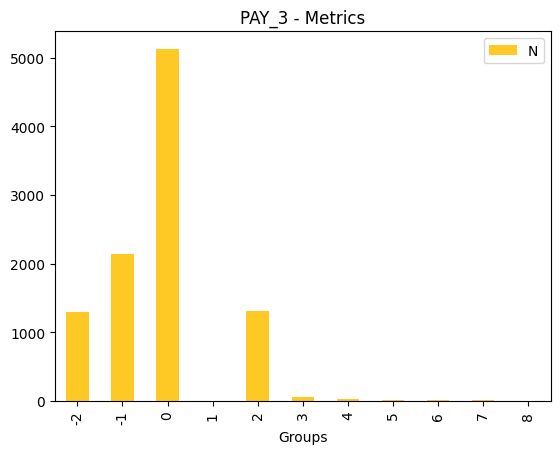

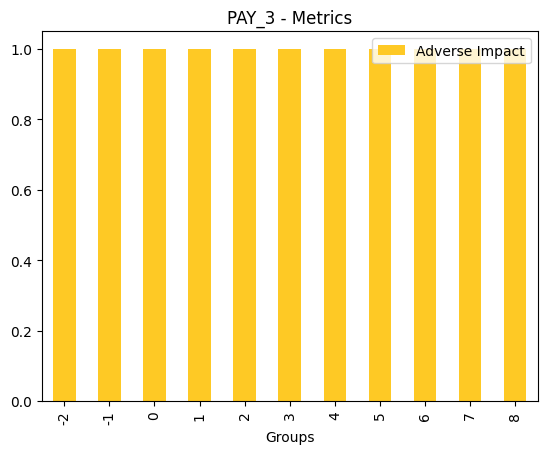

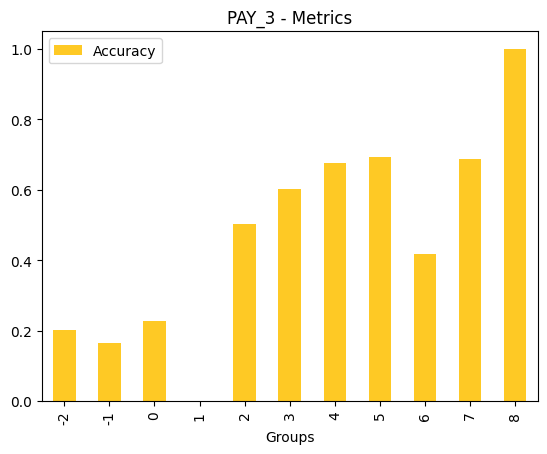

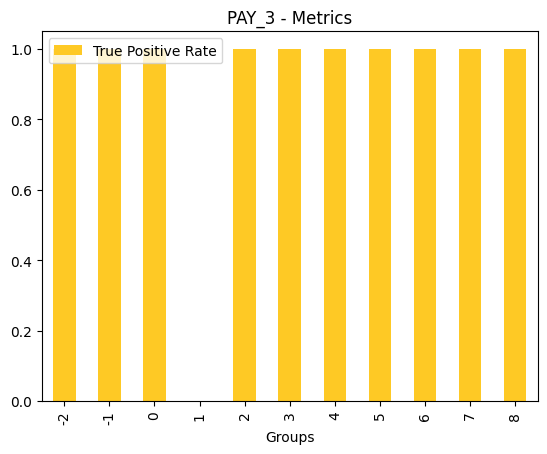

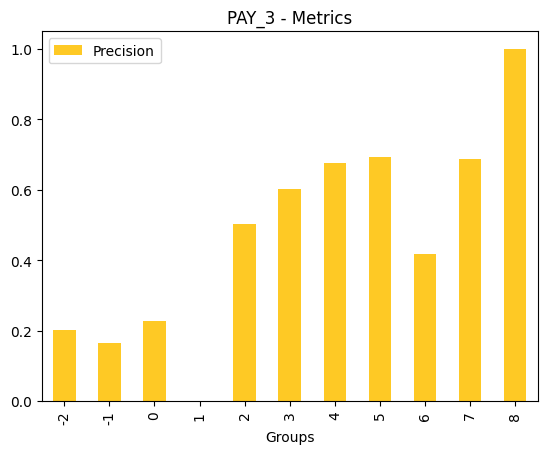

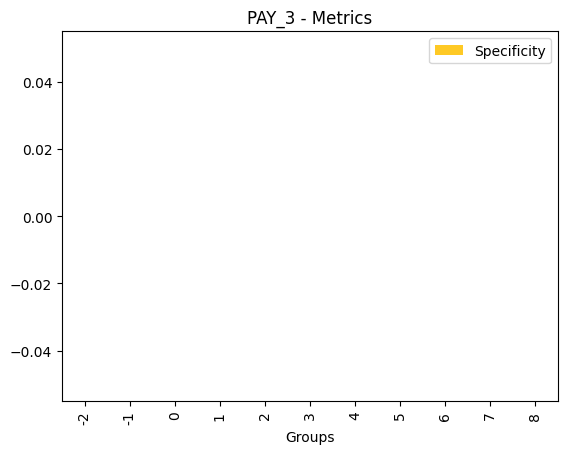

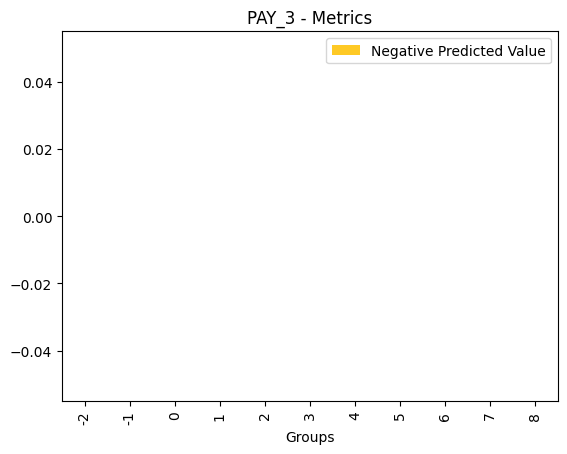

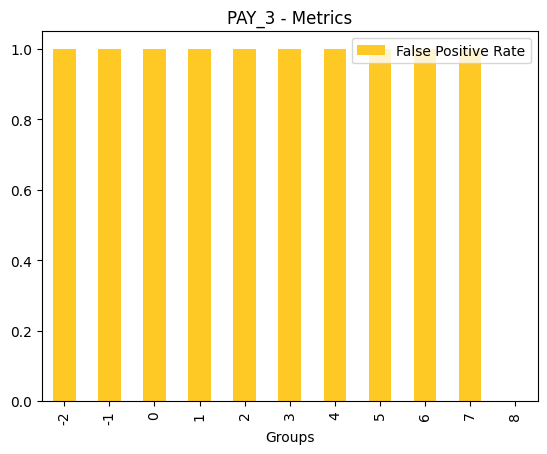

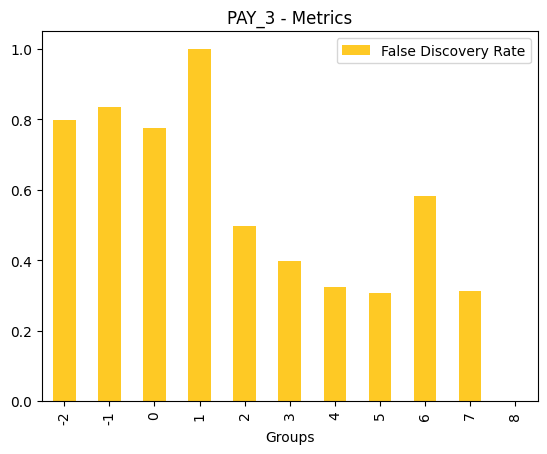

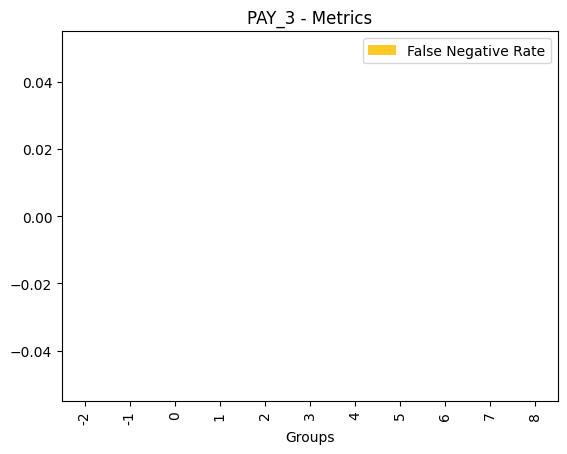

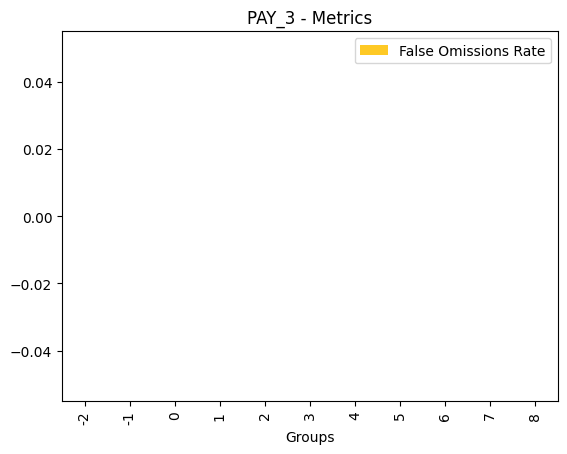

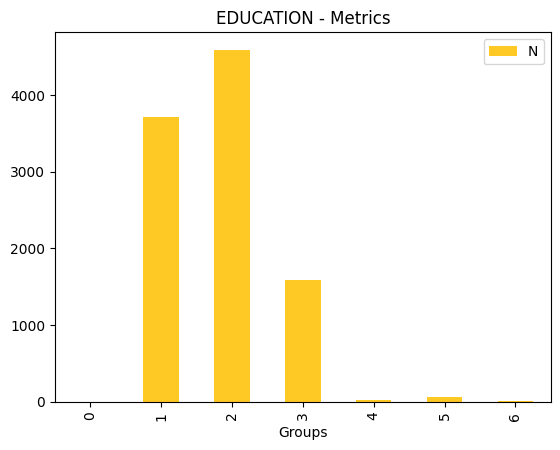

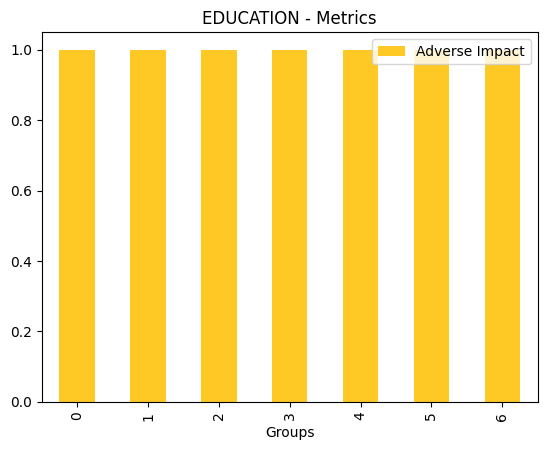

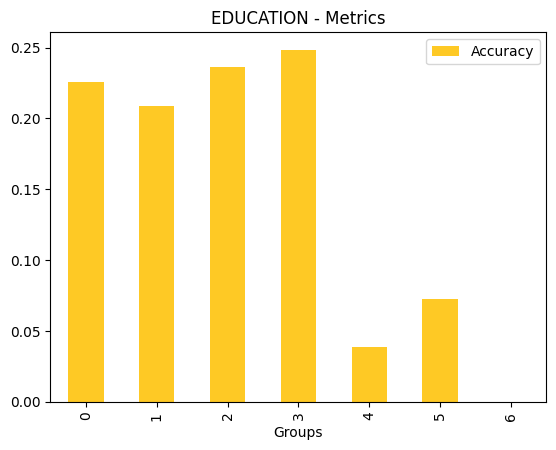

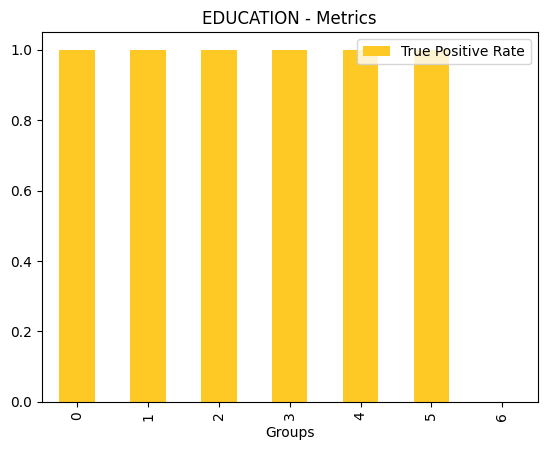

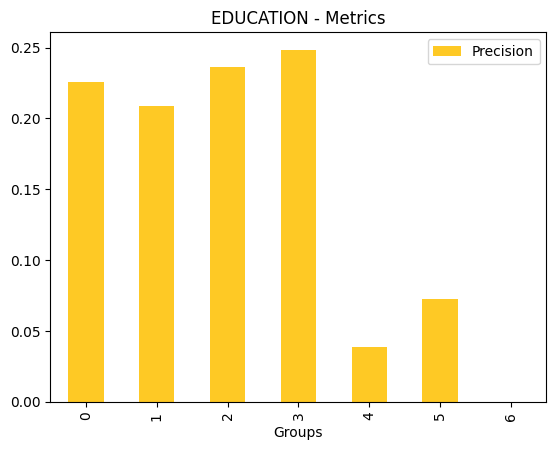

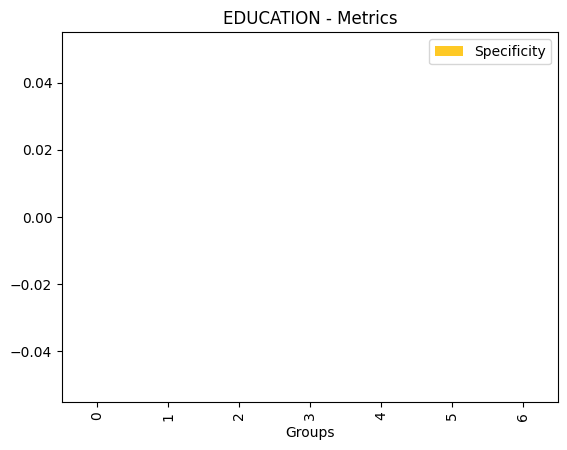

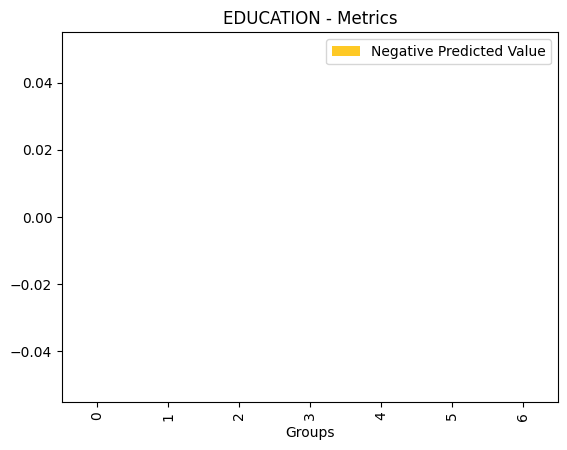

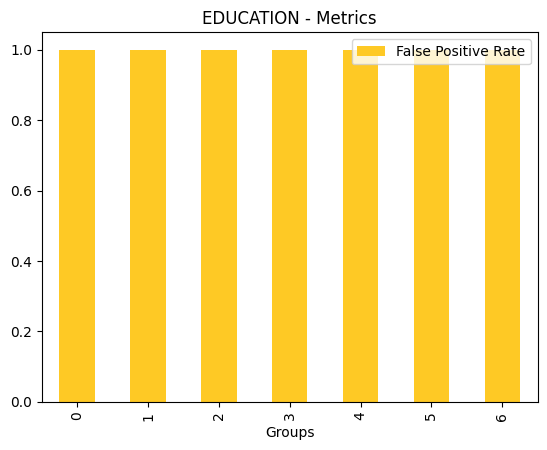

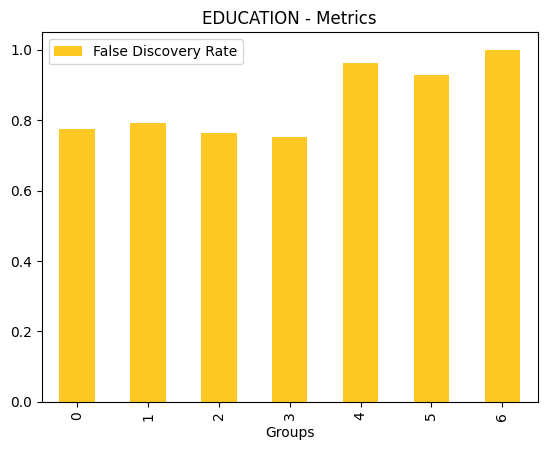

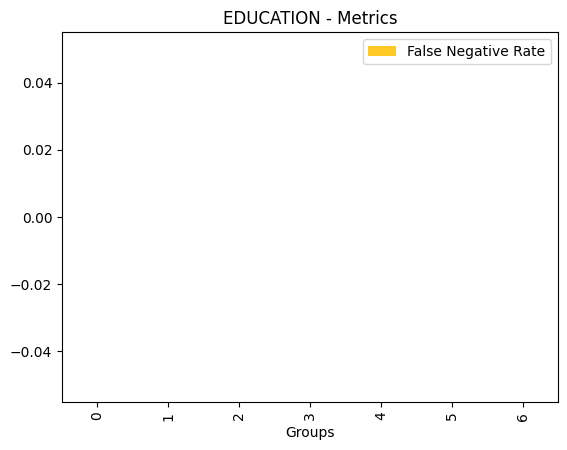

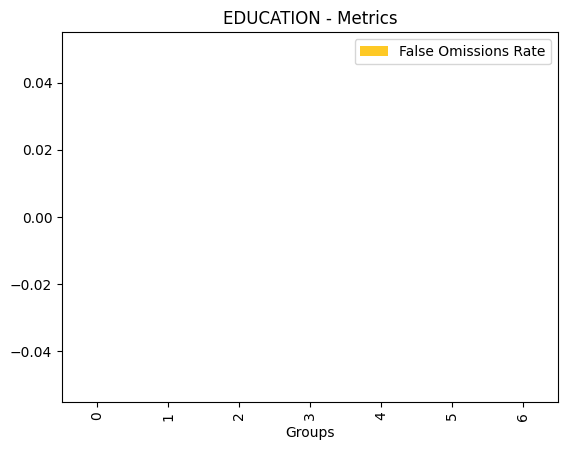

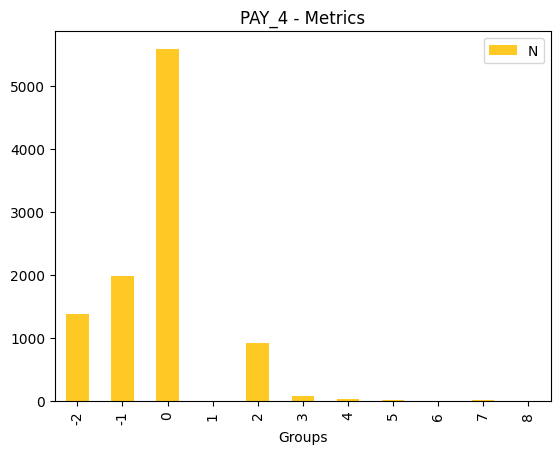

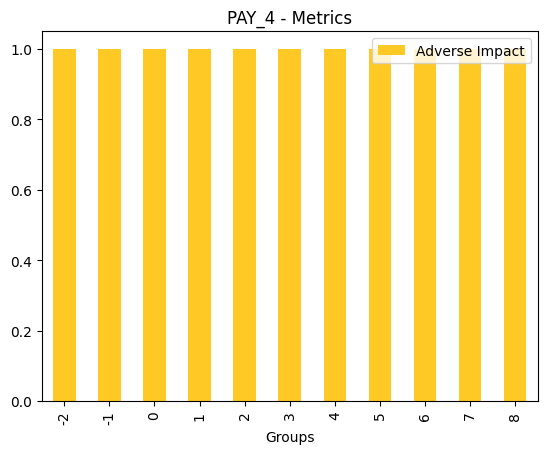

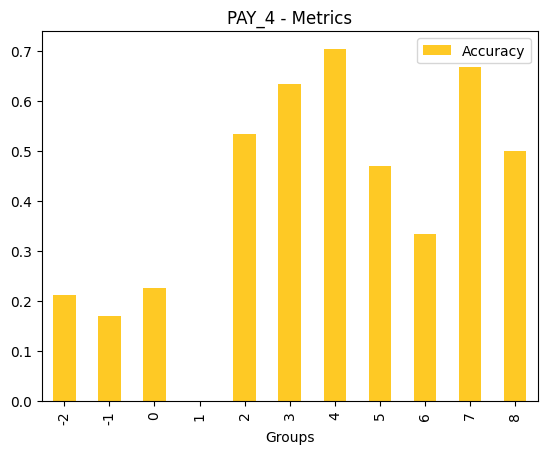

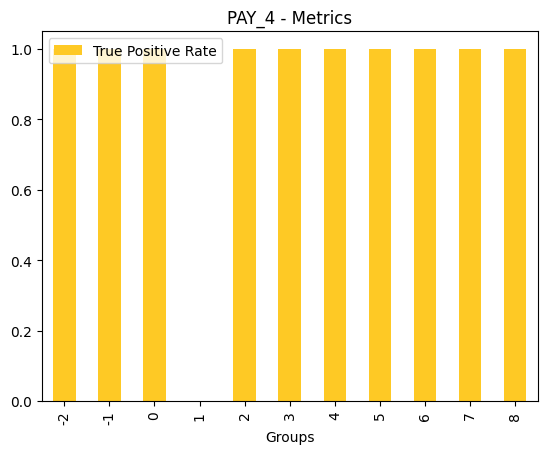

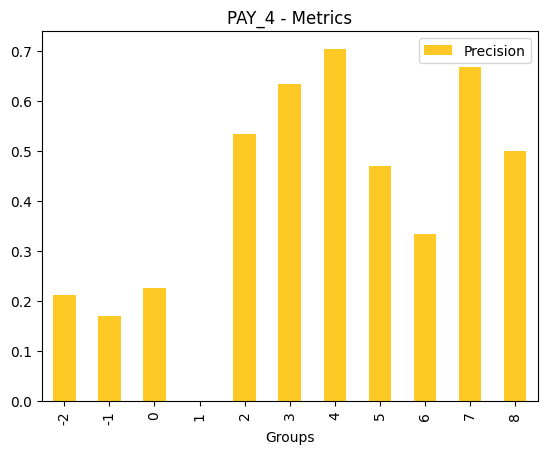

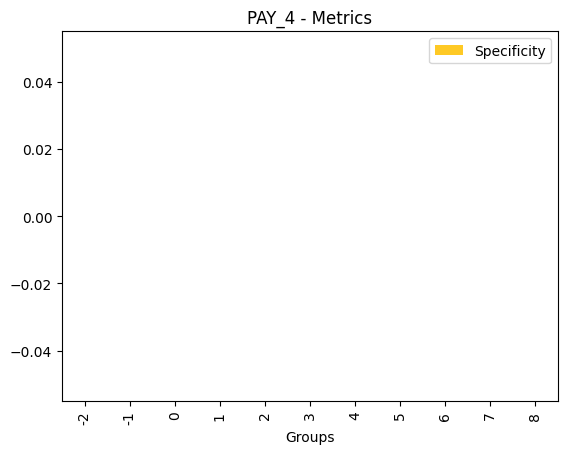

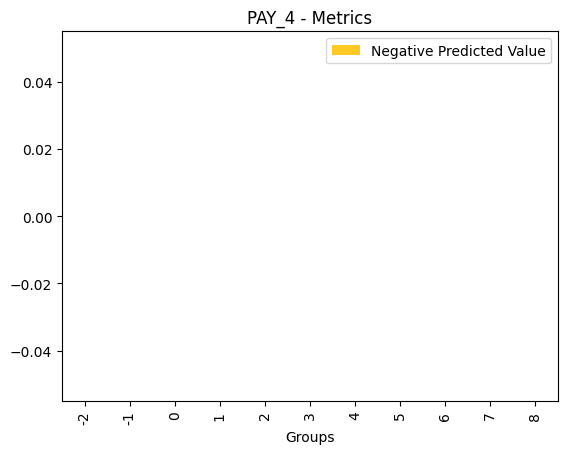

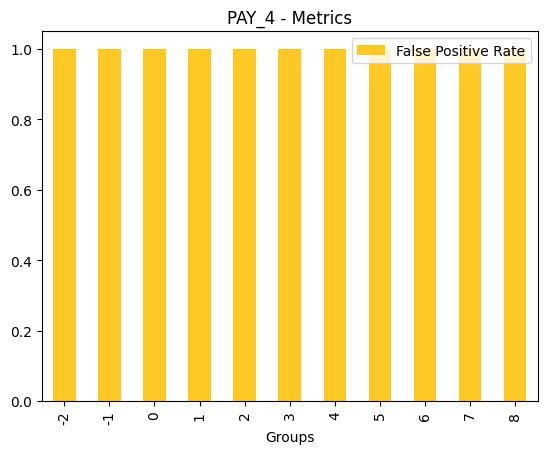

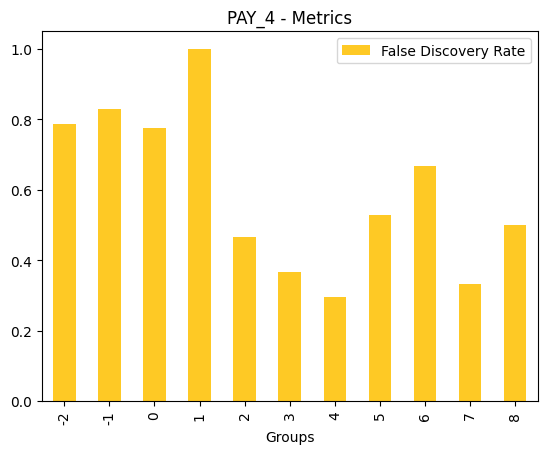

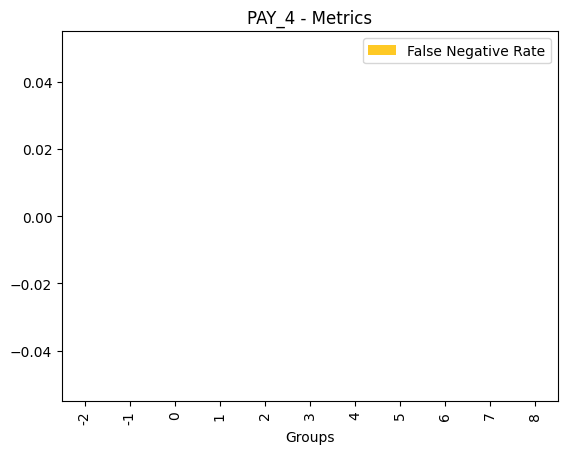

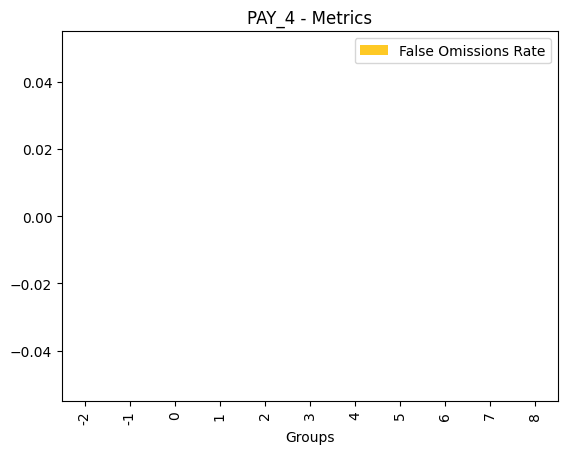

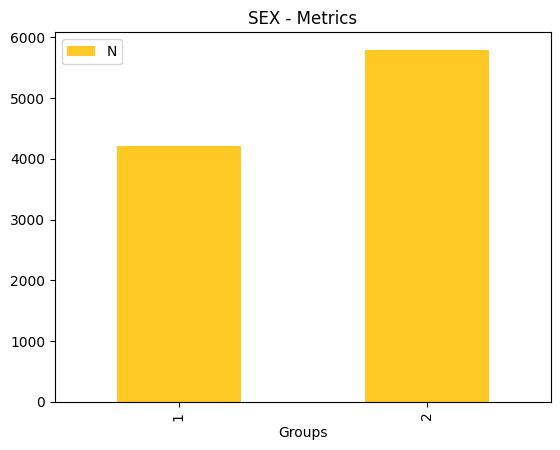

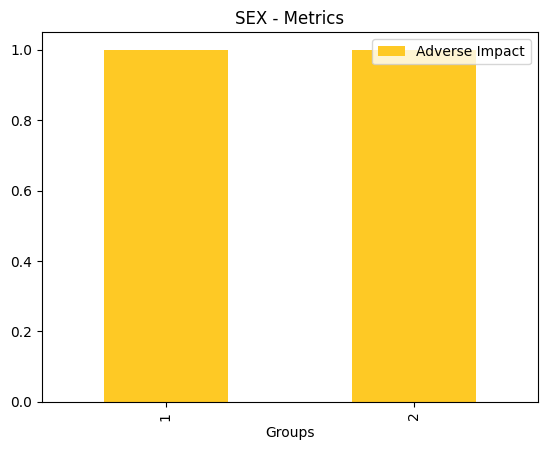

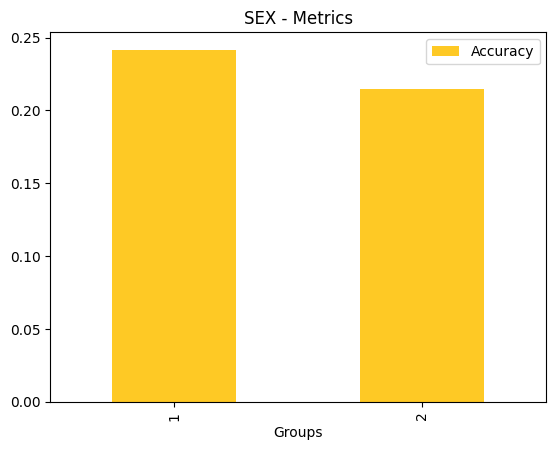

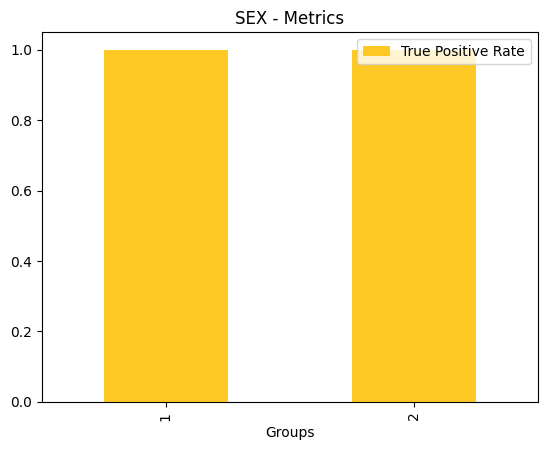

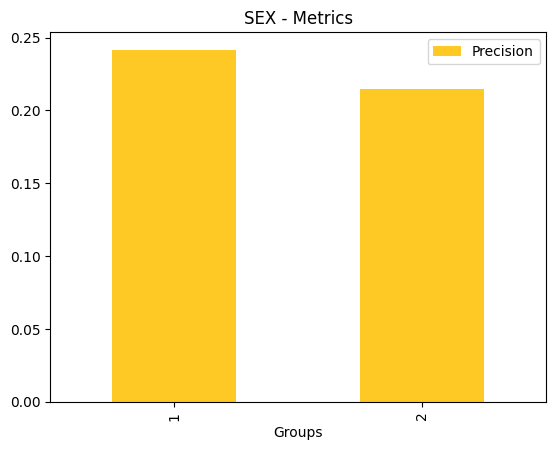

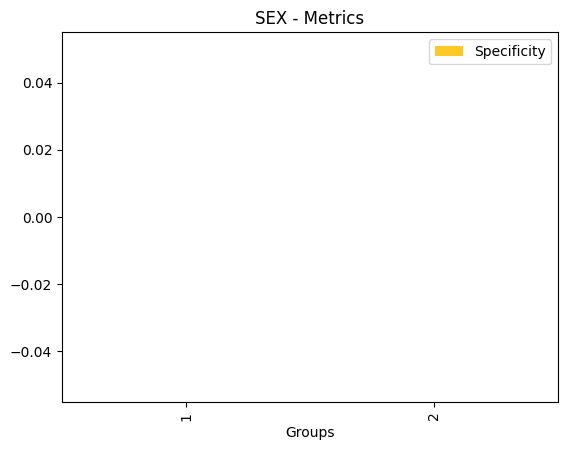

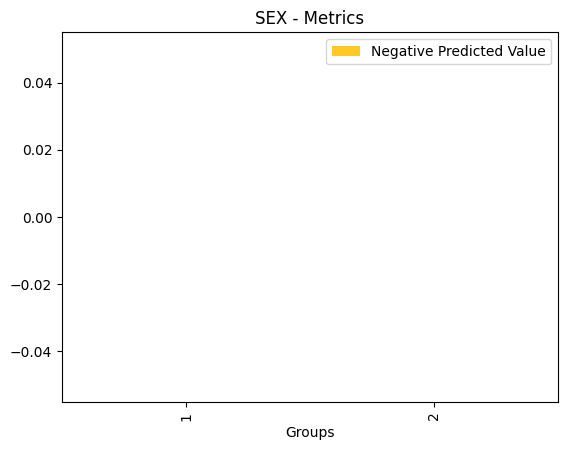

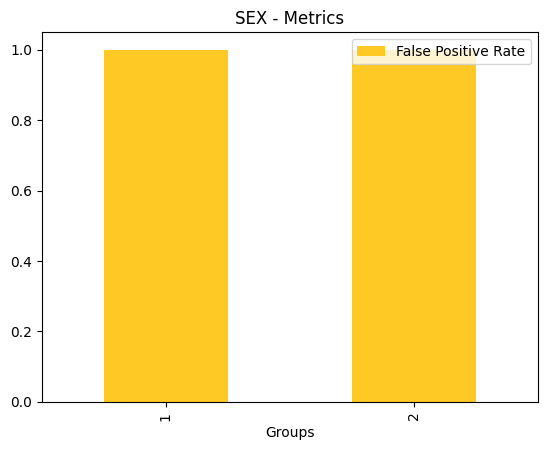

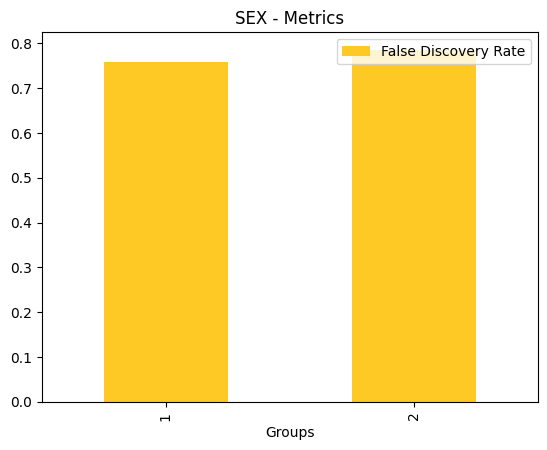

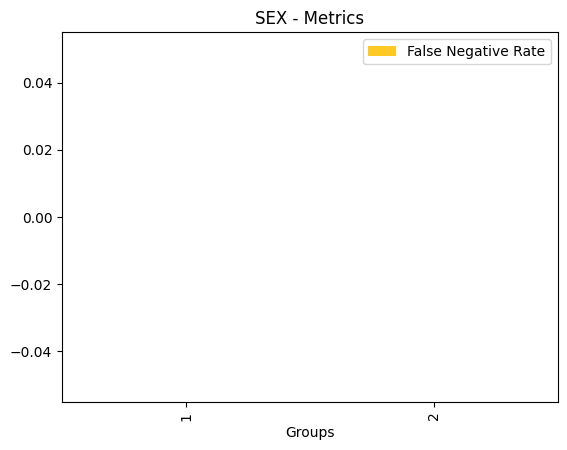

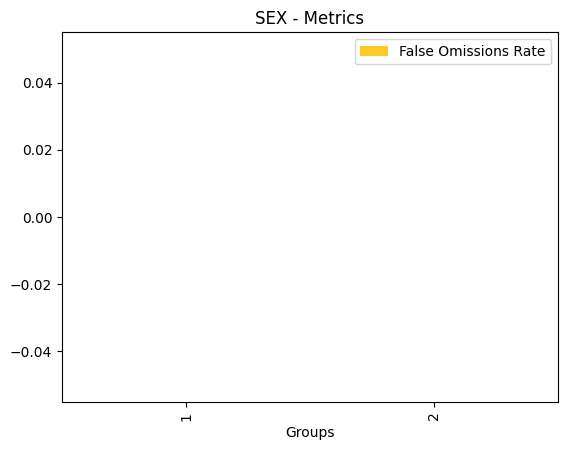

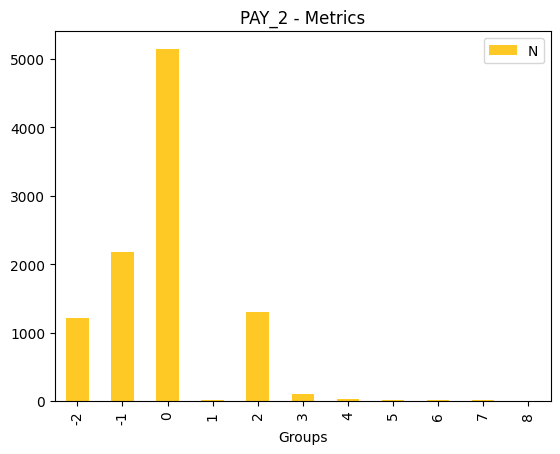

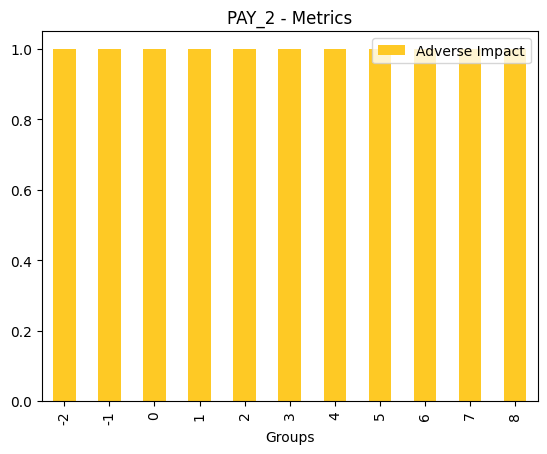

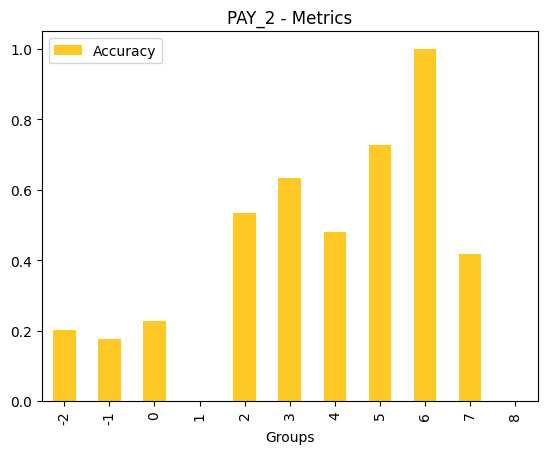

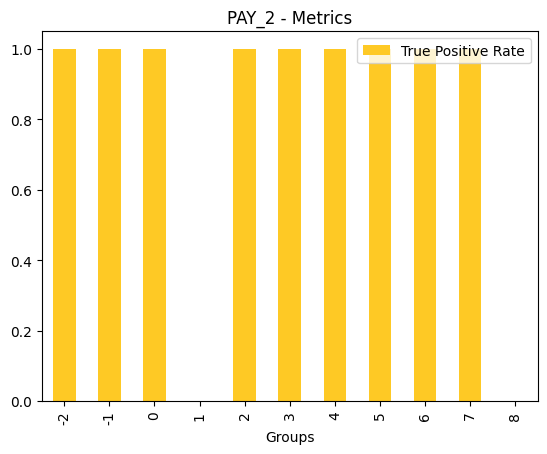

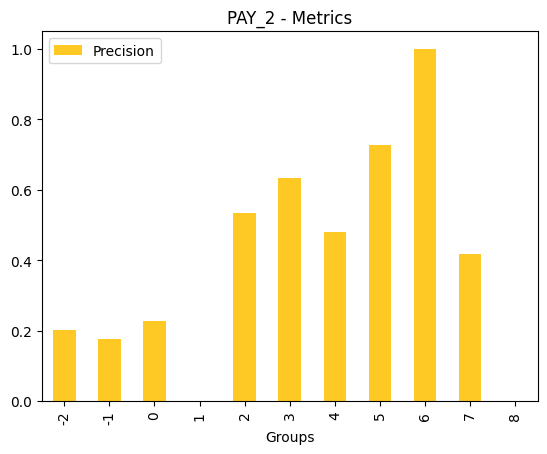

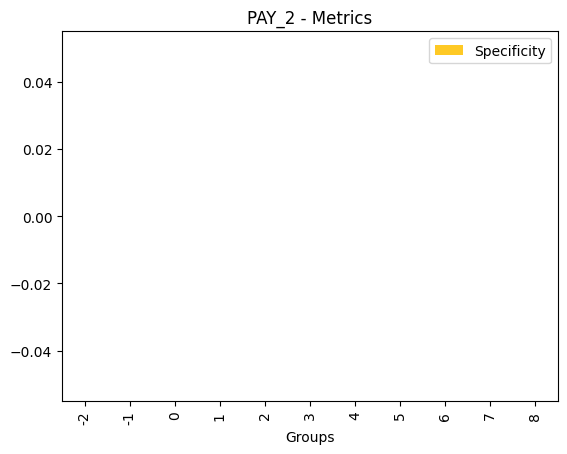

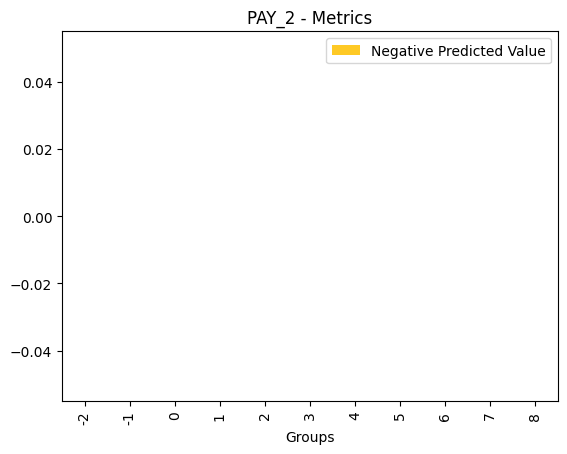

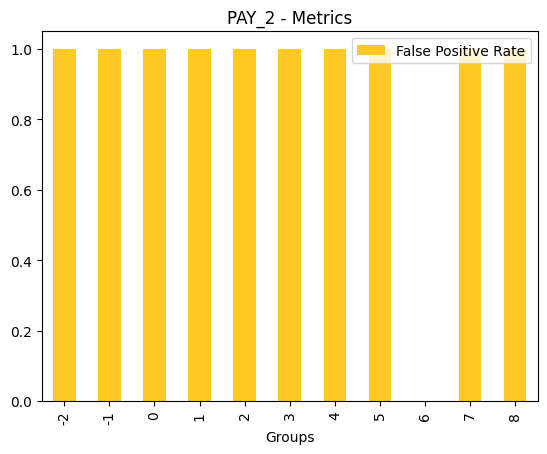

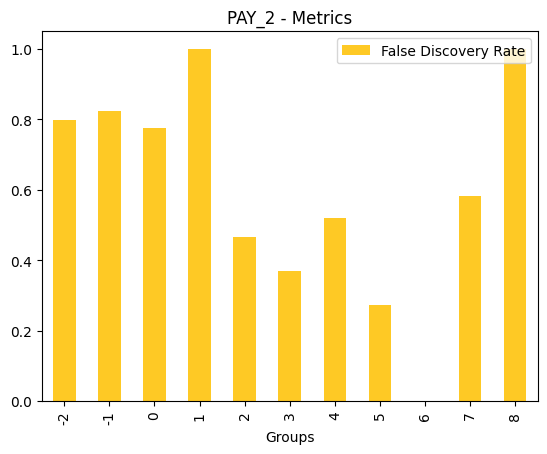

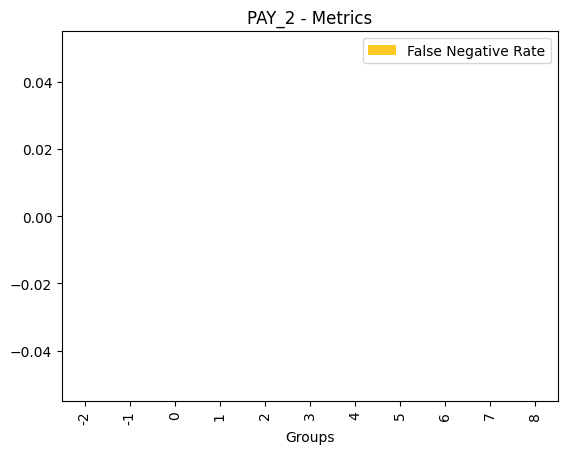

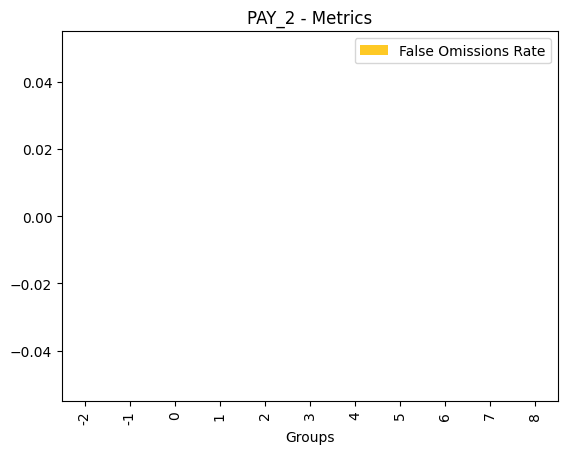

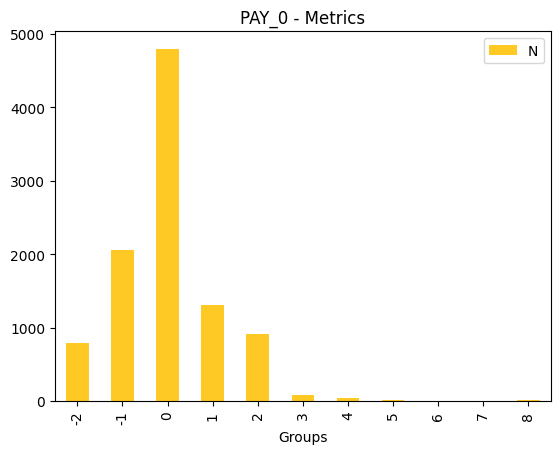

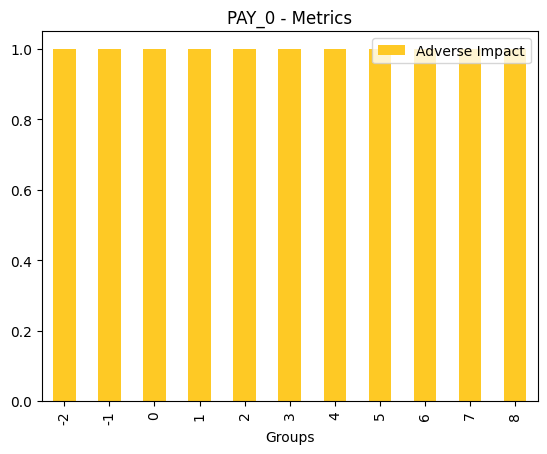

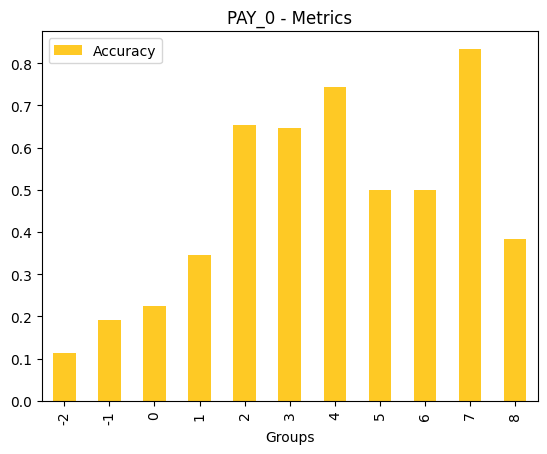

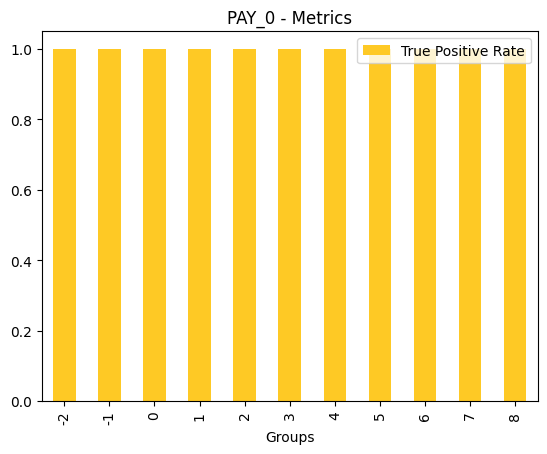

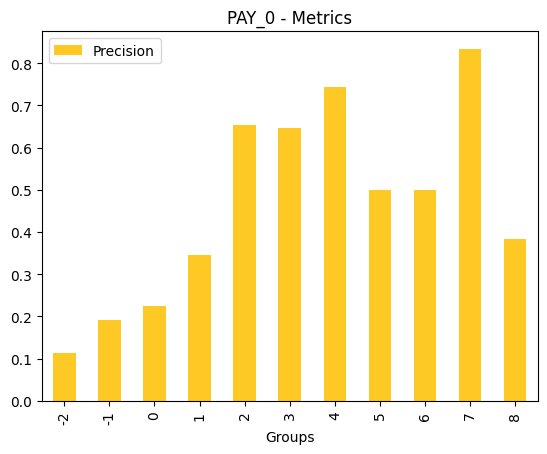

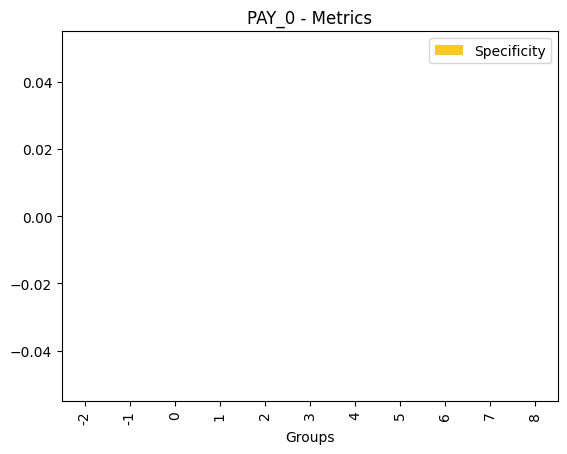

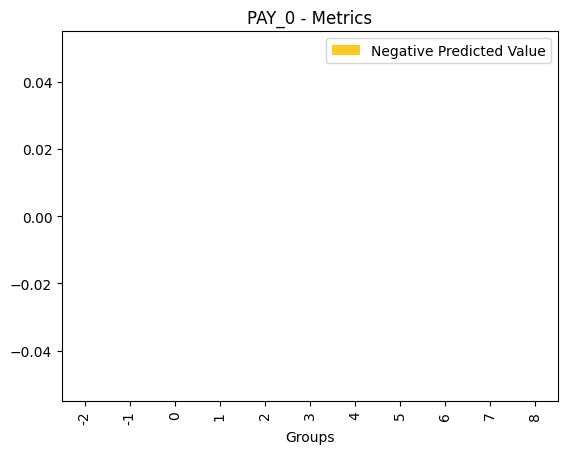

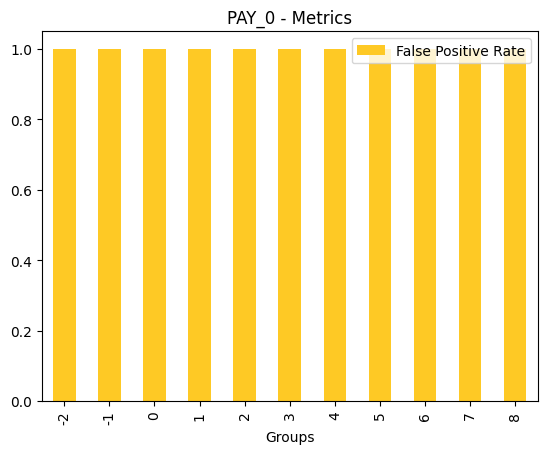

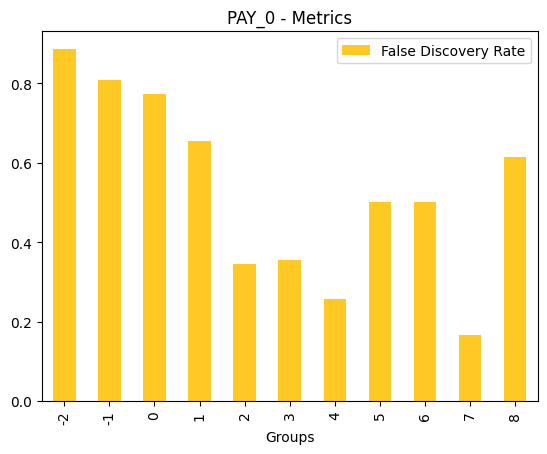

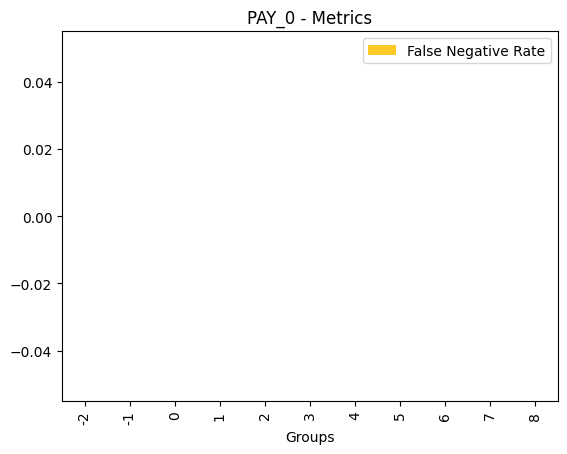

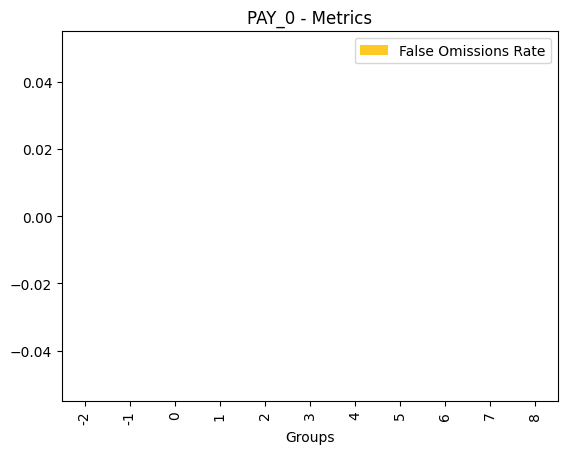

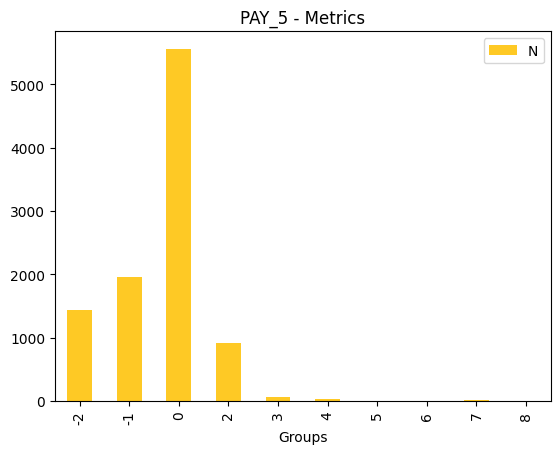

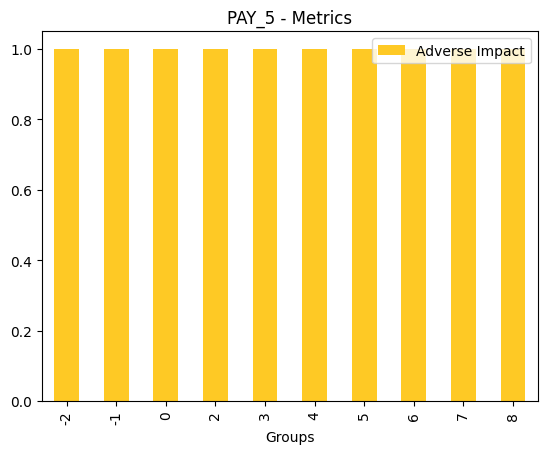

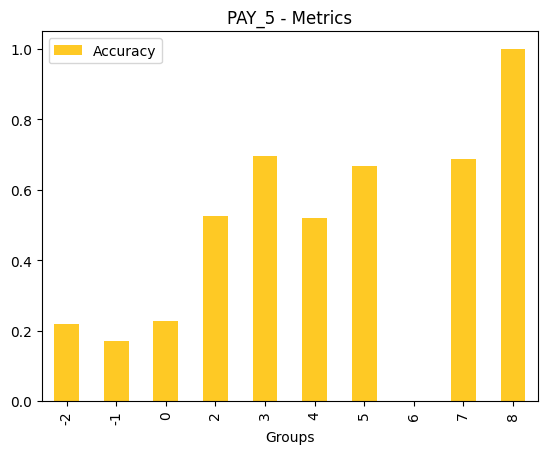

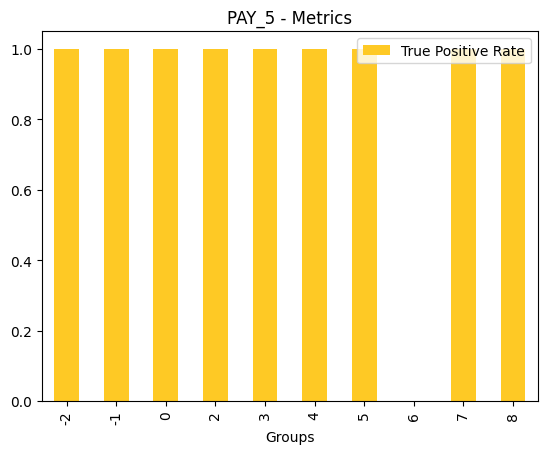

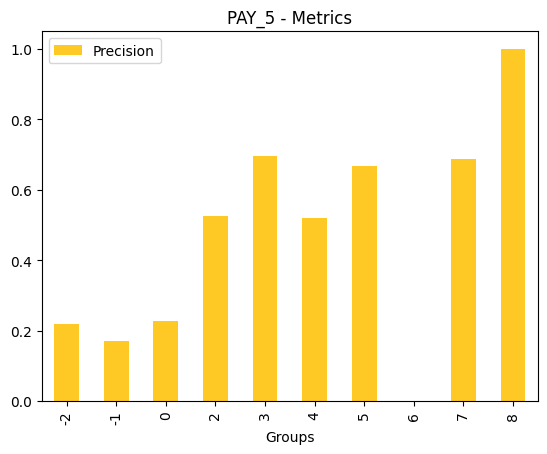

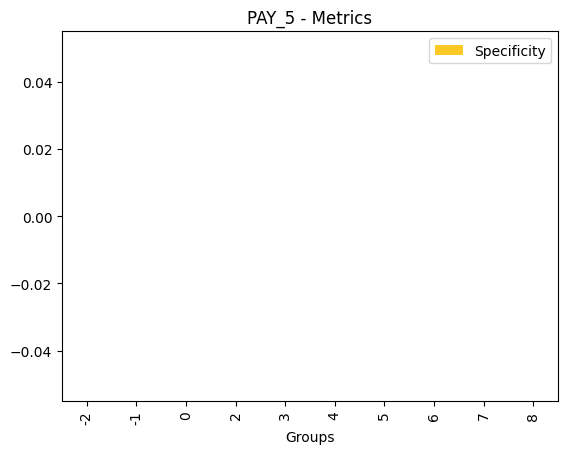

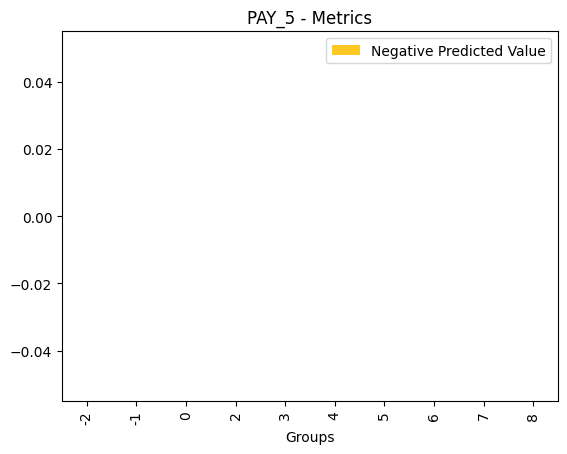

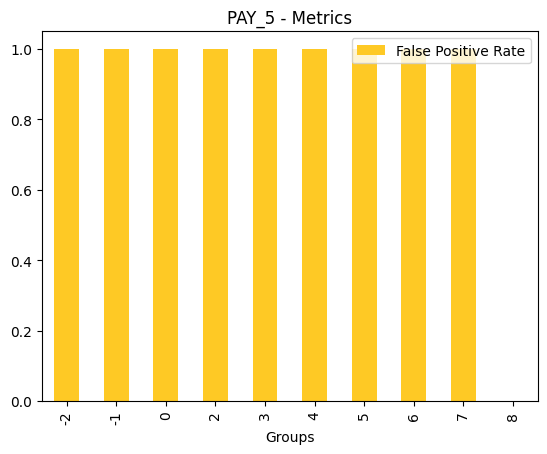

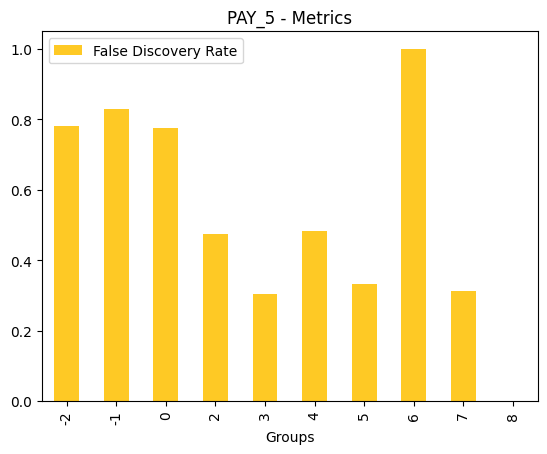

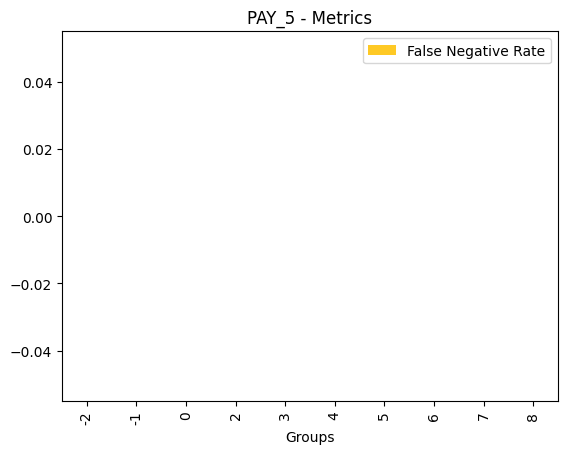

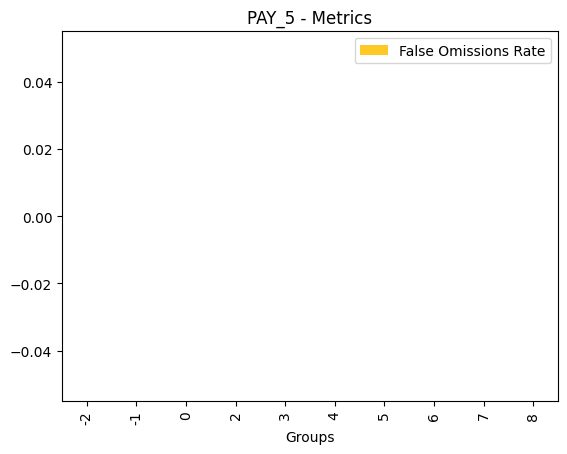

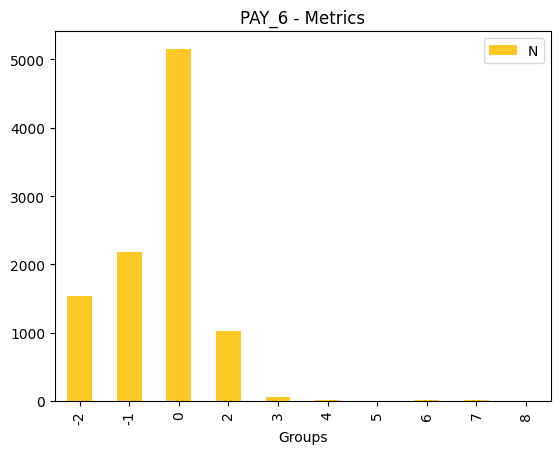

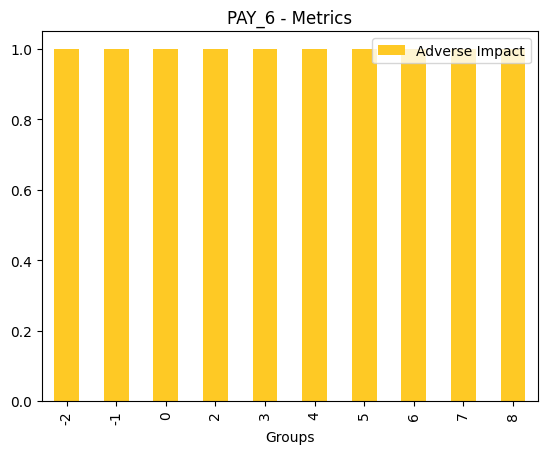

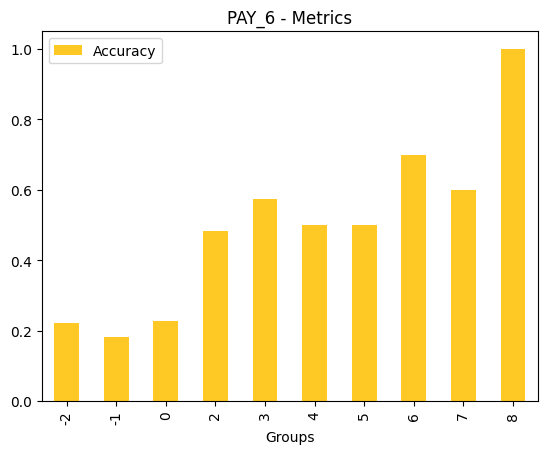

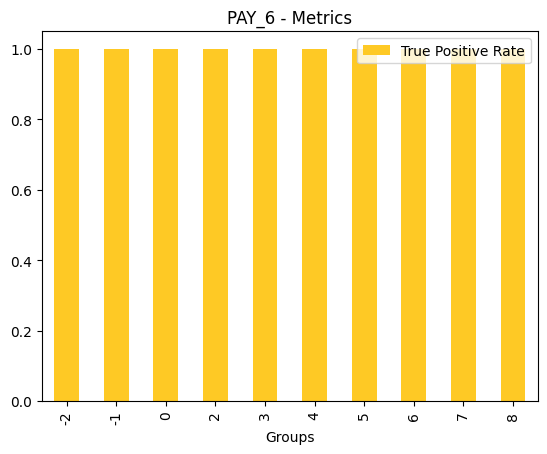

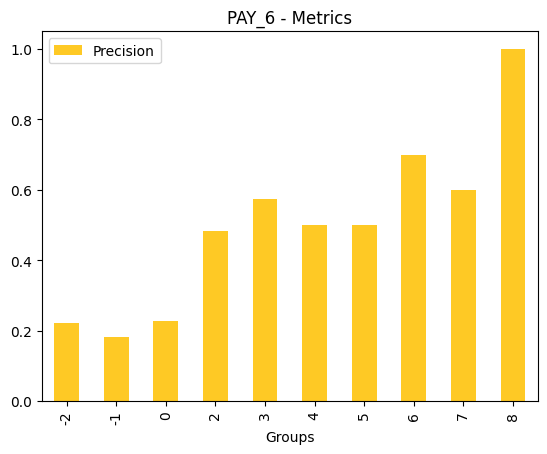

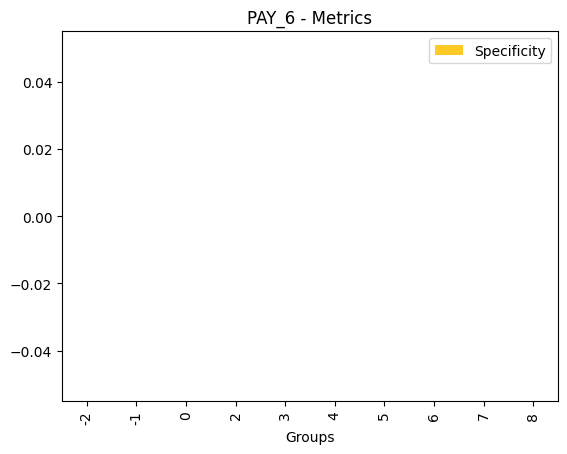

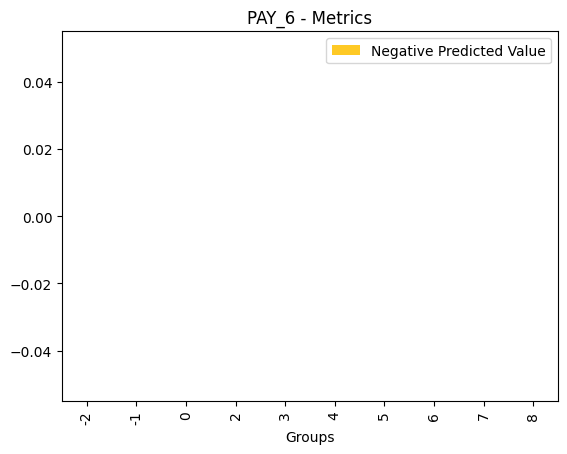

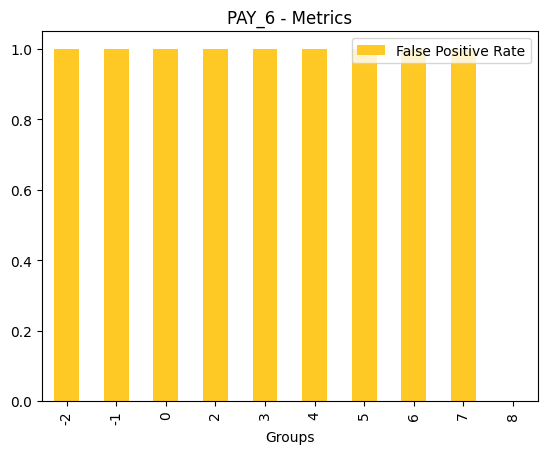

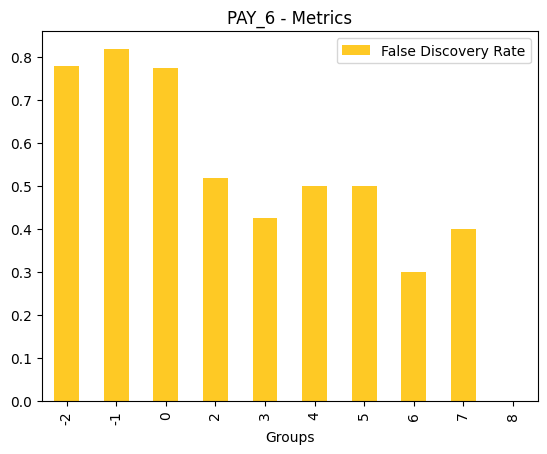

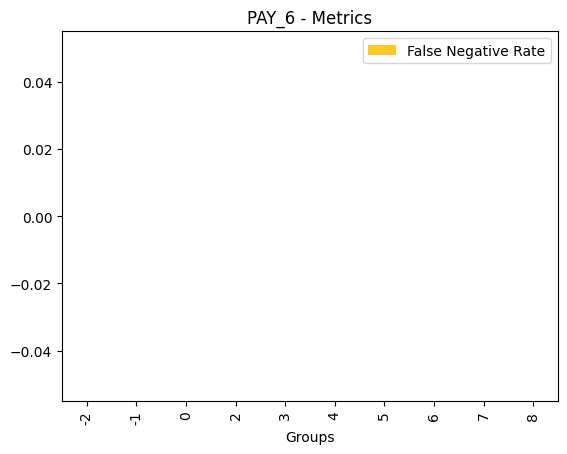

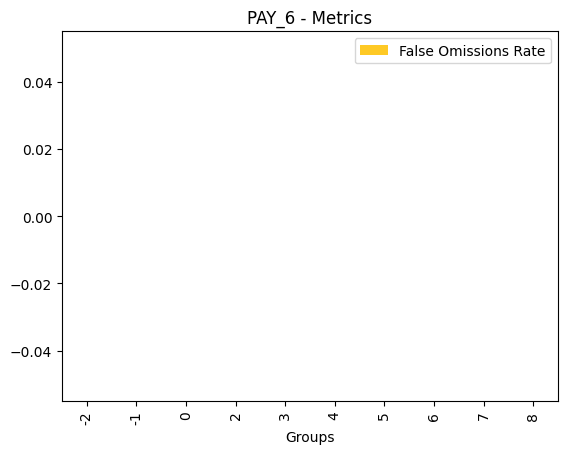

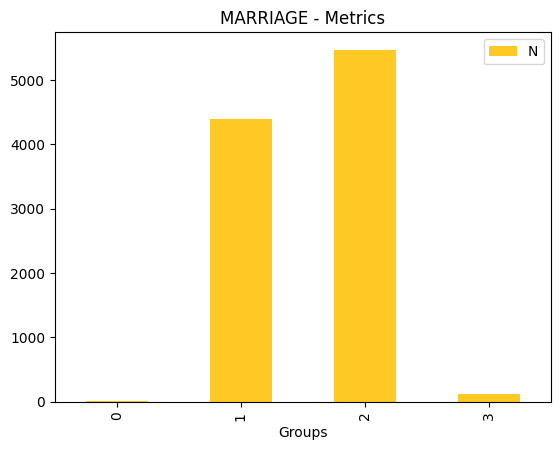

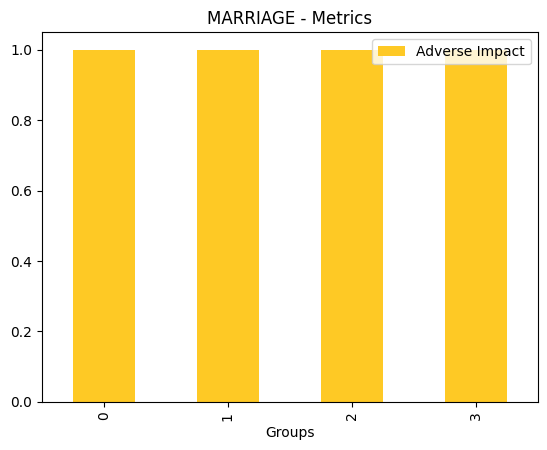

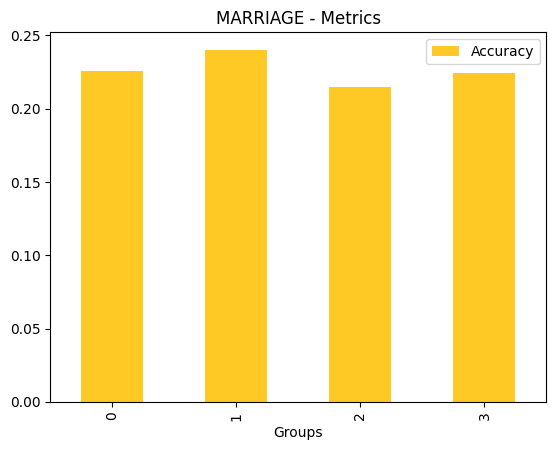

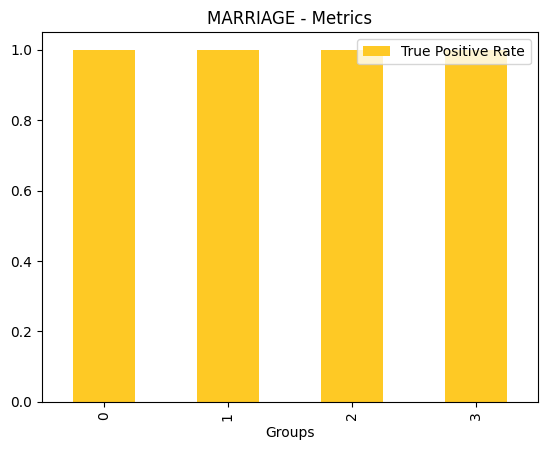

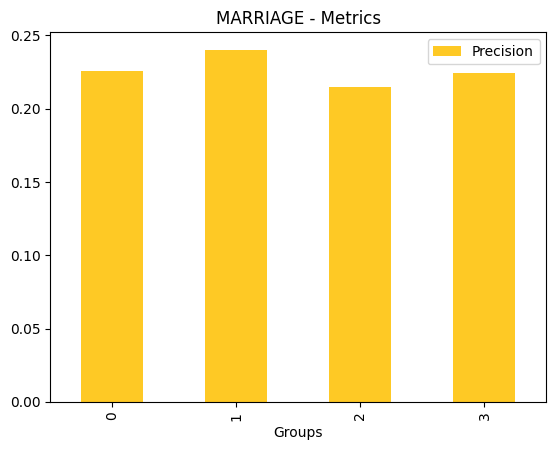

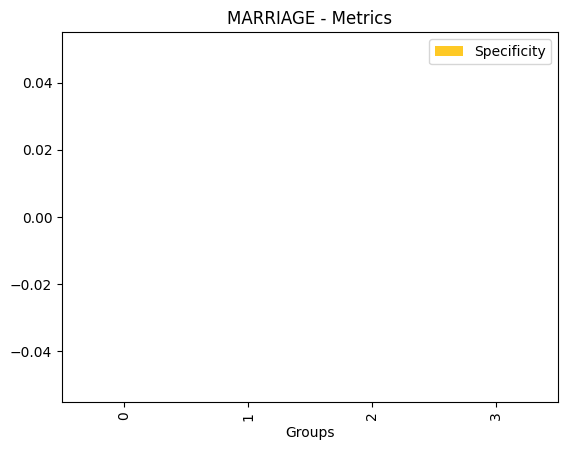

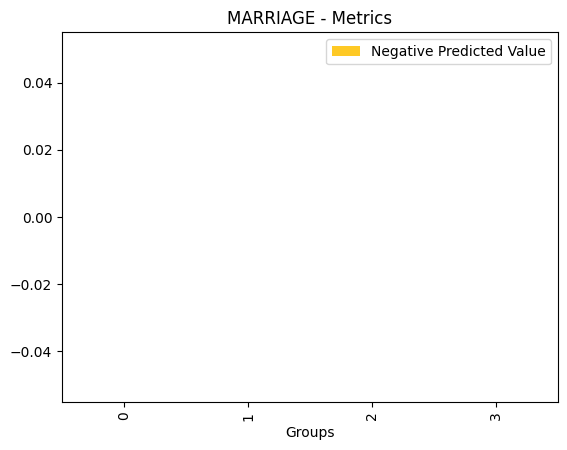

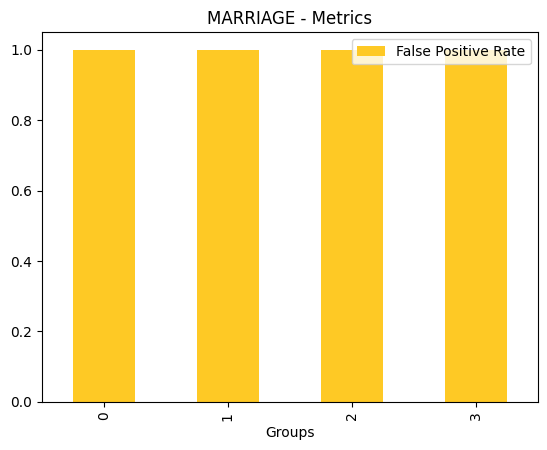

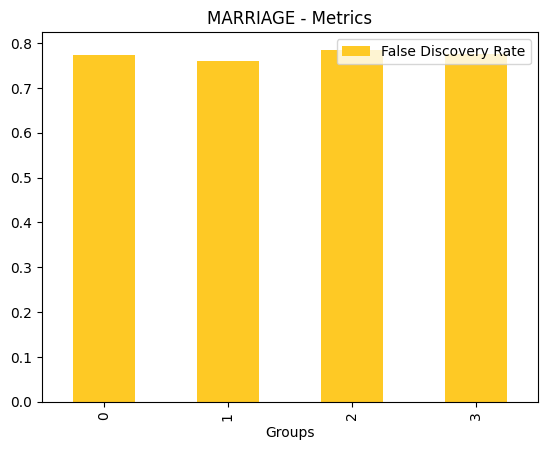

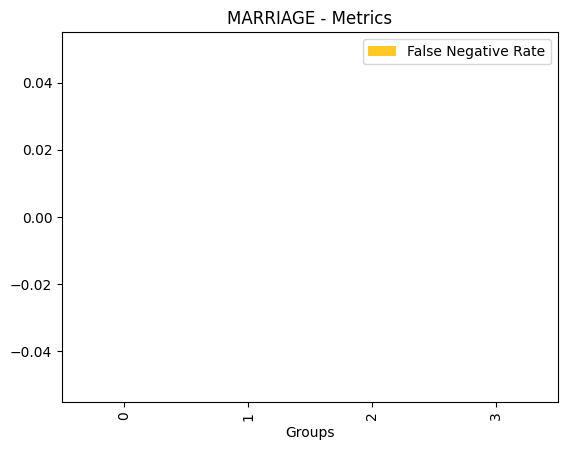

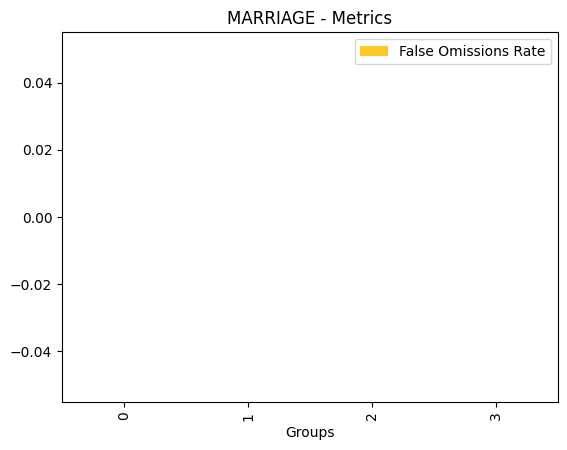

Checking whether there is an H2O instance running at http://localhost:49477 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.18" 2023-01-17; OpenJDK Runtime Environment (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1); OpenJDK 64-Bit Server VM (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1, mixed mode, sharing)
  Starting server from /home/srasaratnam/projects/h2o-sonar/venv/lib/python3.8/site-packages/hmli/backend/bin/hmli.jar
  Ice root: /tmp/tmpl7ck2knw
  JVM stdout: /tmp/tmpl7ck2knw/hmli_srasaratnam_started_from_python.out
  JVM stderr: /tmp/tmpl7ck2knw/hmli_srasaratnam_started_from_python.err
  Server is running at http://127.0.0.1:49477
Connecting to H2O server at http://127.0.0.1:49477 ... successful.


--------------------------  ----------------------------------------------------------------
H2O_cluster_uptime:         01 secs
H2O_cluster_timezone:       America/Toronto
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.34.0.7
H2O_cluster_version_age:    1 year, 2 months and 19 days !!!
H2O_cluster_name:           H2O_from_python_srasaratnam_0tpi7n
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    4 Gb
H2O_cluster_total_cores:    12
H2O_cluster_allowed_cores:  12
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:49477
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         XGBoost, Algos, MLI, MLI-Driver, Core V3, Core V4, TargetEncoder
Python_version:             3.8.10 final
--------------------------  ----------------------------------------------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Connecting to H2O server at http://localhost:49477 ... successful.


--------------------------  ----------------------------------------------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       America/Toronto
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.34.0.7
H2O_cluster_version_age:    1 year, 2 months and 19 days !!!
H2O_cluster_name:           H2O_from_python_srasaratnam_0tpi7n
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    4 Gb
H2O_cluster_total_cores:    12
H2O_cluster_allowed_cores:  12
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:49477
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         XGBoost, Algos, MLI, MLI-Driver, Core V3, Core V4, TargetEncoder
Python_version:             3.8.10 final
--------------------------  ----------------------------------------------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Connecting to H2O server at http://localhost:49477 ... successful.


--------------------------  ----------------------------------------------------------------
H2O_cluster_uptime:         06 secs
H2O_cluster_timezone:       America/Toronto
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.34.0.7
H2O_cluster_version_age:    1 year, 2 months and 19 days !!!
H2O_cluster_name:           H2O_from_python_srasaratnam_0tpi7n
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.999 Gb
H2O_cluster_total_cores:    12
H2O_cluster_allowed_cores:  12
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:49477
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         XGBoost, Algos, MLI, MLI-Driver, Core V3, Core V4, TargetEncoder
Python_version:             3.8.10 final
--------------------------  ----------------------------------------------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
contributions progress: |████████████████████████████████████████████████████████| (done) 100%
h2o_sonar.explainers.summary_shap_explainer.SummaryShapleyExplainer: progress 30.0%
h2o_sonar.explainers.summary_shap_explainer.SummaryShapleyExplainer: progress 40.0%
h2o_sonar.explainers.summary_shap_explainer.SummaryShapleyExplainer: progress 50.0%
h2o_sonar.explainers.summary_shap_explainer.SummaryShapleyExplainer: progress 50.0%

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


h2o_sonar.explainers.summary_shap_explainer.SummaryShapleyExplainer: progress 90.0%
h2o_sonar.explainers.summary_shap_explainer.SummaryShapleyExplainer: progress 90.0%
h2o_sonar.explainers.summary_shap_explainer.SummaryShapleyExplainer: progress 90.0%
h2o_sonar.explainers.summary_shap_explainer.SummaryShapleyExplainer: progress 90.0%
h2o_sonar.explainers.summary_shap_explainer.SummaryShapleyExplainer: progress 100.0%
h2o_sonar.explainers.summary_shap_explainer.SummaryShapleyExplainer: progress 100.0%
h2o_sonar.explainers.pd_ice_explainer.PdIceExplainer: progress 10.0%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
h2o_sonar.explainers.pd_ice_explainer.PdIceExplainer: progress 20.0%
h2o_sonar.explainers.pd_ice_explainer.PdIceExplainer: progress 20.0%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gb

<Figure size 640x480 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

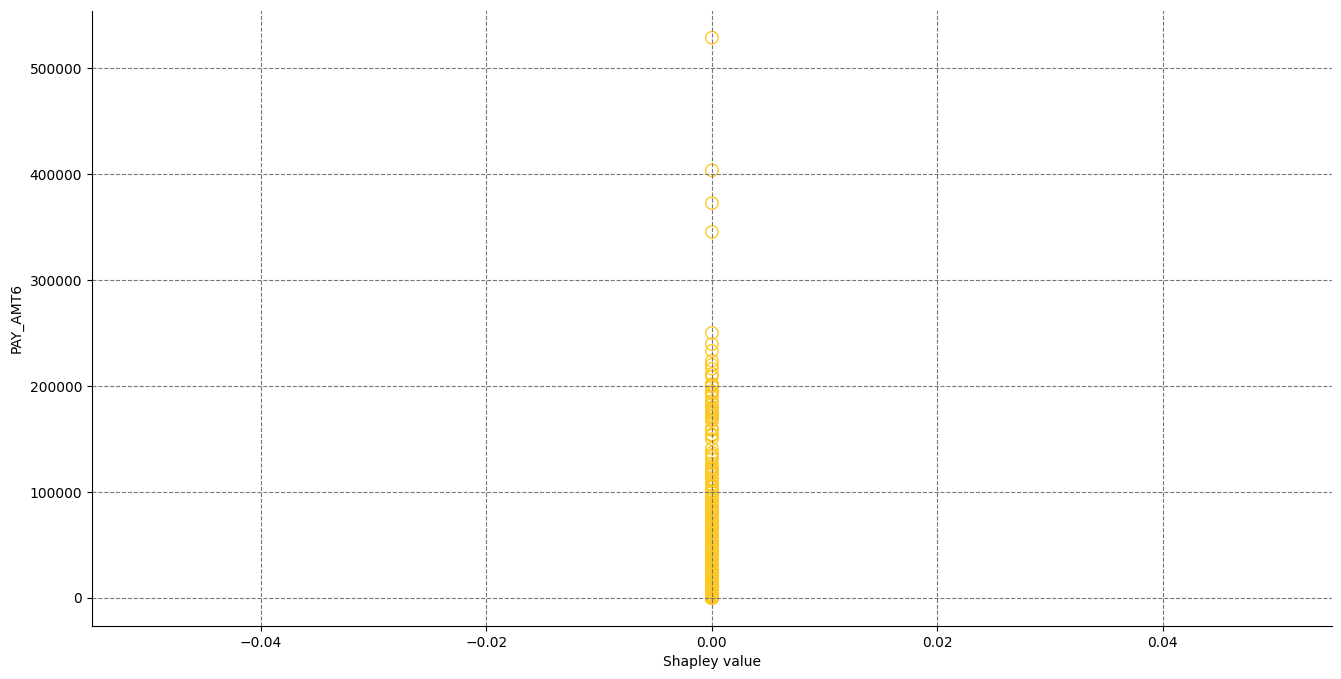

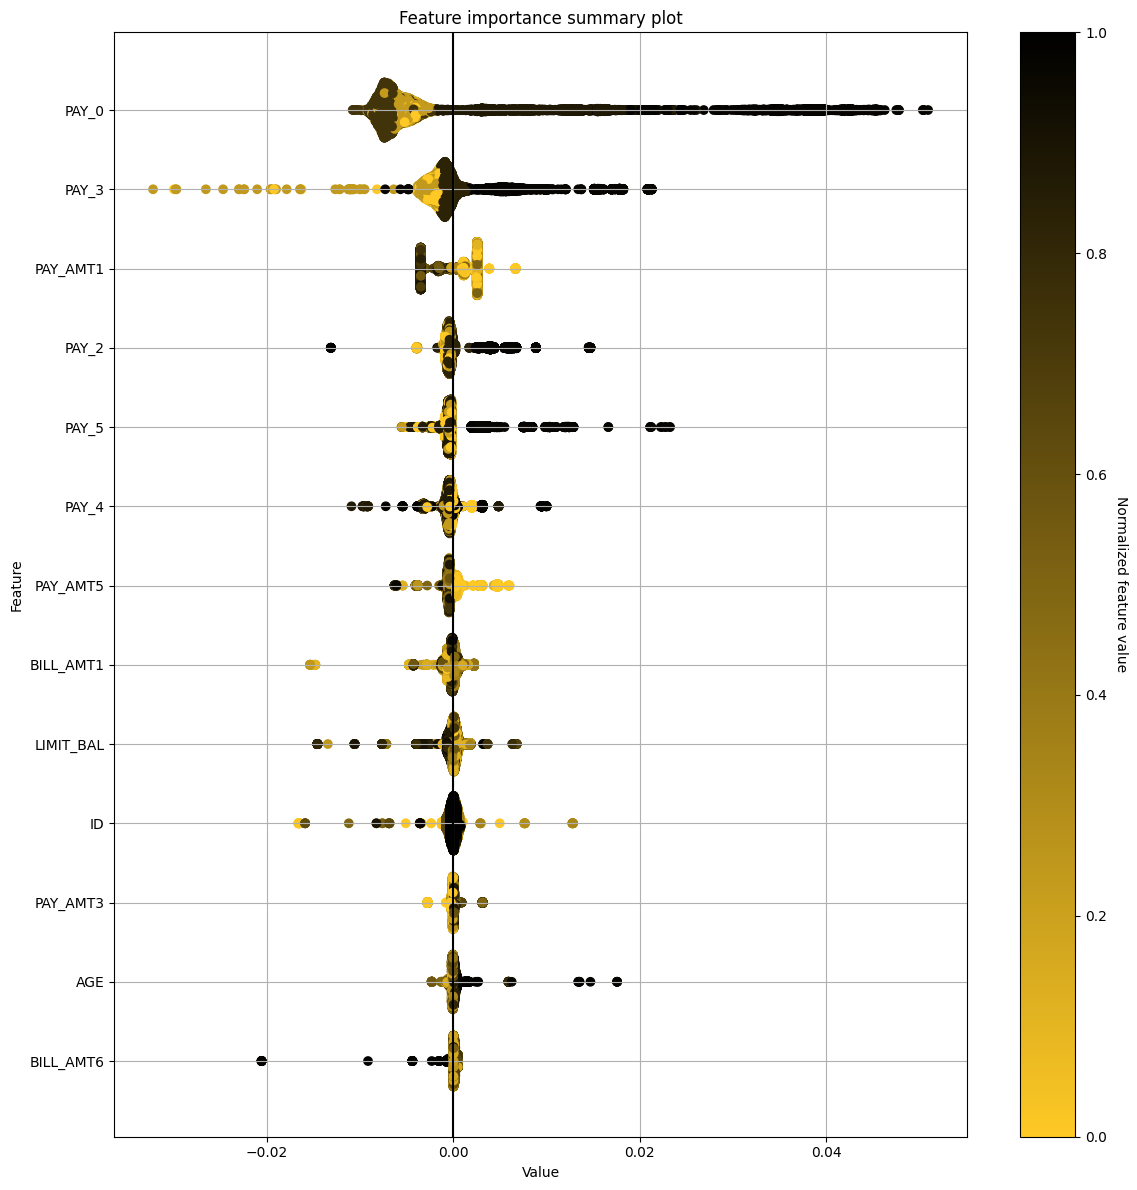

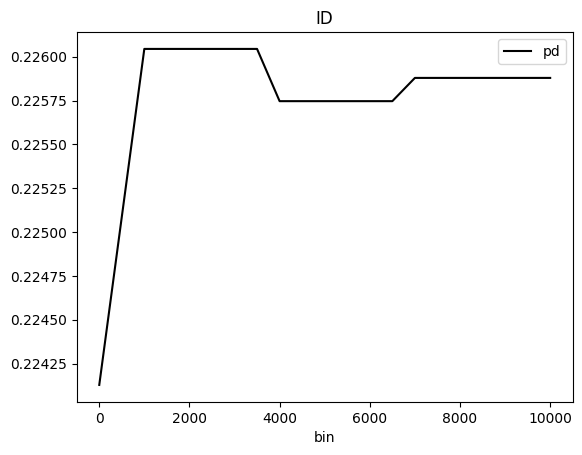

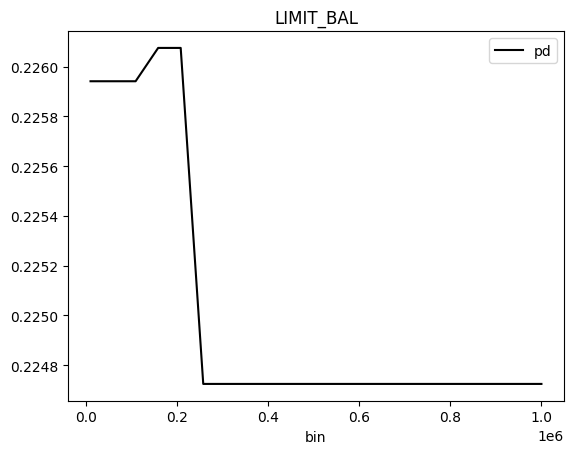

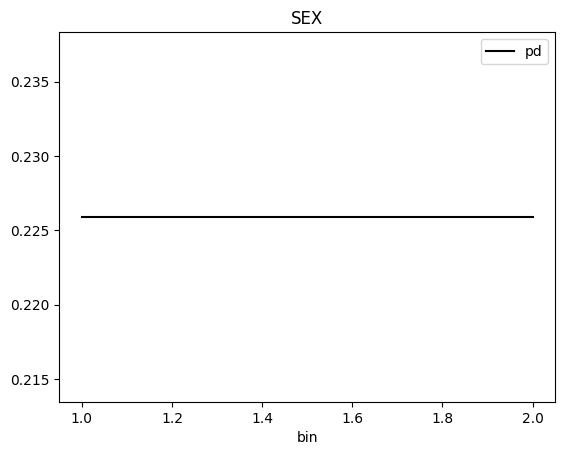

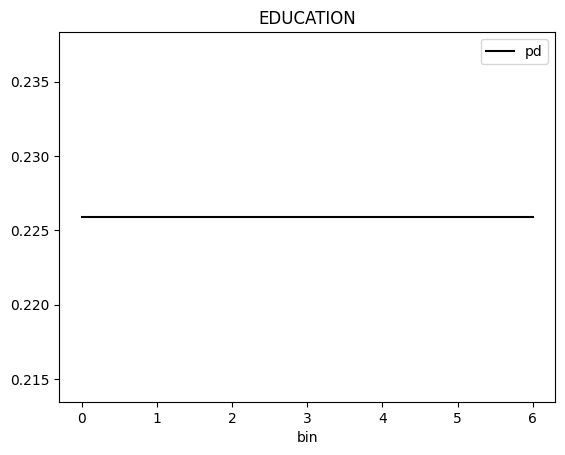

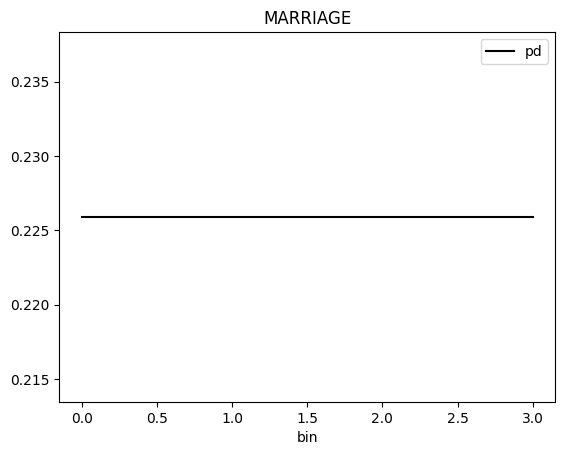

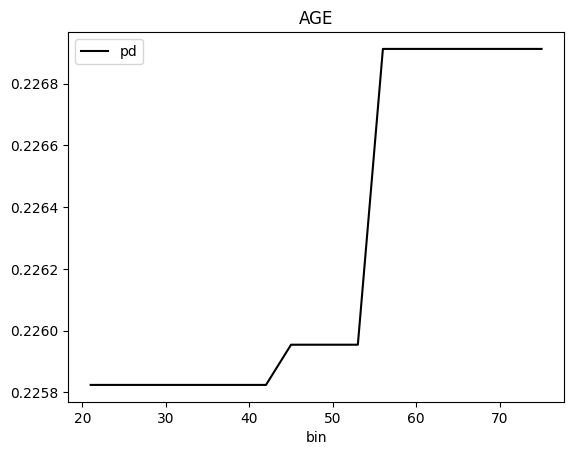

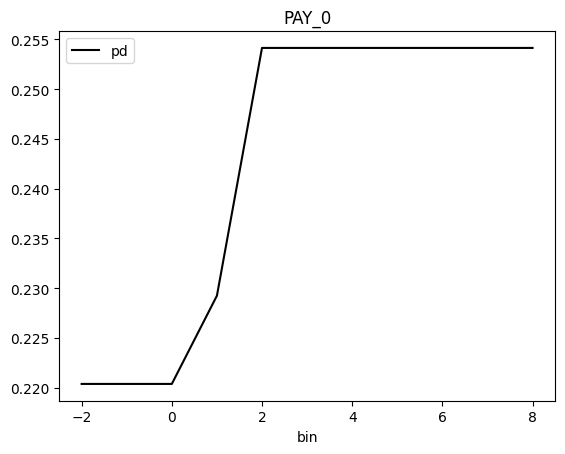

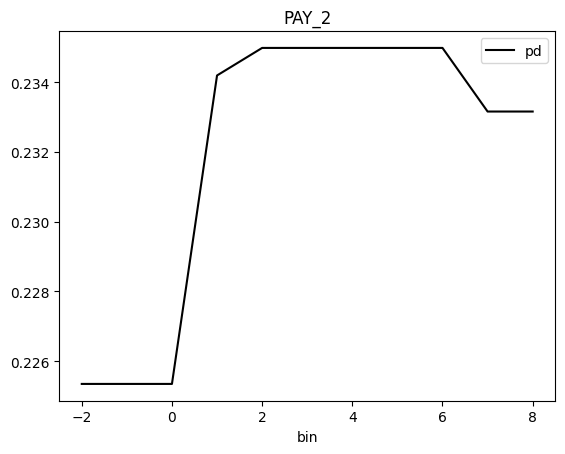

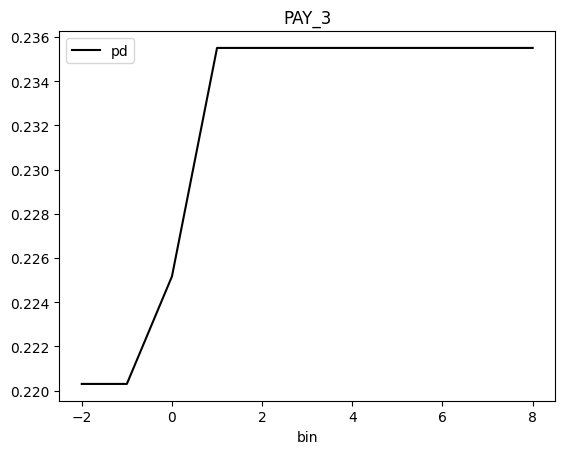

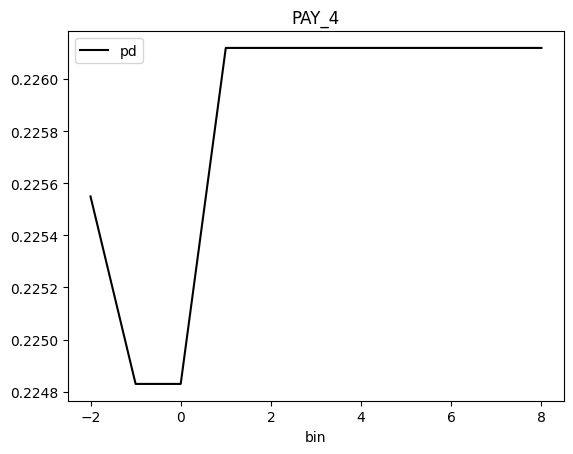

H2O session _sid_b8b9 closed.


In [10]:
# H2O model
results_location = "../../results"

# run Interpretation
interpretation = interpret.run_interpretation(
    dataset=dataset_path,
    model=gradient_booster,
    target_col=target_col,
    results_location=results_location,
    used_features=X,
)

# optionally make ExplainableModel() object to provide additional metadata
# h2o_model = ExplainableModel(
#     predict_method=gradient_booster.predict,
#     model_src=gradient_booster,
#     model_type=ExplainableModelType.h2o3,
#     model_meta=ExplainableModelMeta(target_col=target_col)
# )

In [11]:
# open interpretation HTML report in web browser
webbrowser.open(interpretation.result.get_html_report_location())

True

In [14]:
# View results directory
!tree {interpretation.persistence.base_dir}

../../results/h2o-sonar/mli_experiment_ec9dcd6a-d4d6-41fa-b3a7-c2a422a92c7f
├── explainer_h2o_sonar_explainers_dia_explainer_DiaExplainer_a137f765-547c-42b7-a985-94eadb305a3d
│   ├── global_disparate_impact_analysis
│   │   ├── text_plain
│   │   │   └── explanation.txt
│   │   └── text_plain.meta
│   ├── global_html_fragment
│   │   ├── text_html
│   │   │   ├── dia-0-accuracy.png
│   │   │   ├── dia-0-adverse_impact.png
│   │   │   ├── dia-0-false_discovery_rate.png
│   │   │   ├── dia-0-false_negative_rate.png
│   │   │   ├── dia-0-false_omissions_rate.png
│   │   │   ├── dia-0-false_positive_rate.png
│   │   │   ├── dia-0-negative_predicted_value.png
│   │   │   ├── dia-0-n.png
│   │   │   ├── dia-0-precision.png
│   │   │   ├── dia-0-specificity.png
│   │   │   ├── dia-0-true_positive_rate.png
│   │   │   ├── dia-1-accuracy.png
│   │   │   ├── dia-1-adverse_impact.png
│   │   │   ├── dia-1-false_discovery_rate.png
│   │   │   ├── dia-1-false_negative_rate.png
│   │   │   ├── dia-1

In [15]:
h2o.cluster().shutdown()

H2O session _sid_abae closed.
